# A Key Driver Analysis of the Trade Price of Dalian Commodity Exchange's Iron Ore Futures


A key driver analysis of the trade price of Dalian Commodity Exchange's Iron Ore Futures, through the study of relationship between the iron ore futures' trade price with i.) the global financial market performance and ii.) the indicator indices of the steel related market.

A mix of machine learning and statistical methodes are applied for feature selection. After selecting the set of final features, either a simple or Ridge regression model is trained, depending on the number of selected features, to study the relationship between the dependent and independent variables. Below is a figure of the workflow of the project:



![workflow](https://raw.githubusercontent.com/fredmfcheng/commodity_futures/master/fig%203.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1)


from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error

from itertools import compress

from pylab import rcParams    
rcParams['figure.figsize'] = 20,15
import pylab as pl
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('weekly_data_DCE.xlsx')
df.shape

(232, 41)

In [3]:
# data is in weekly level
df.head()   

year month  week   DCE_Vol  DCE(TARGET)     VIX    DJI_Vol           DJI  \
0  2016   Jan     2  814.5057    36.435041  22.526  692150000  16782.196002   
1  2016   Jan     3  608.2197    34.239949  24.592  796840000  16241.175176   
2  2016   Jan     4  744.0621    35.849137  25.938  866430000  15943.811033   
3  2016   Jan     5  787.2714    36.073661  22.476  727870000  16149.236518   
4  2016   Feb     6  751.5636    37.503247  21.766  653030000  16309.048340   

     FTSE_Vol         FTSE  N225_Vol          N225  SSE_Composite_Index_Vol  \
0  3997330000  6021.056140    767000  18058.879667                  1047200   
1  4728020000  5892.413800    854700  17397.512078                  1085200   
2  4671800000  5794.697956    904200  16629.135823                   938000   
3  4547870000  5963.587502    894300  17177.185268                   937300   
4  4917320000  5907.885992   1173000  17315.663802                   774500   

   SSE_Composite_Index   aud_usd  brl_usd  cny_usd   sgd_usd     jpy_usd  \
0          3267.453398  0.714680  0.24824  6.53024  1.427848  119.006000   
1          2982.899883  0.696999  0.24818  6.57082  1.438008  117.637602   
2          2942.544804  0.692208  0.24430  6.57016  1.437050  117.399402   
3          2757.709205  0.701053  0.24608  6.56880  1.429306  118.515399   
4          2744.789454  0.711268  0.25460  6.56522  1.418194  119.404399   

    vale_Vol      vale   bhp_Vol        bhp  rio_tinto_Vol  rio_tinto  \
0  101244100  2.838551  25216600  23.507695       25279000  26.766019   
1  139418400  2.373831  29066900  20.884296       35402600  24.393417   
2  158093200  2.299157  32215000  20.420251       31075300  23.482381   
3  121212200  2.278868  20840400  21.559989       25013400  23.983408   
4  131702200  2.487634  21833700  21.920600       28597500  25.656248   

   SSE_real_estate_Vol  SSE_real_estate  180_infrastructure_Vol  \
0                29800      6062.455876              5952658900   
1                30700      5562.881796              6469584800   
2                29100      5521.048268              7218605300   
3                26900      5216.685823              6132310100   
4                23100      5272.423308              4568193300   

   180_infrastructure  CSI_steel_Vol    CSI_steel  china_auto_Vol  china_auto  \
0         1882.495574    14112235700  1377.121504      1010028959    6.236943   
1         1734.322357    15280512200  1282.287303       575206409    6.659128   
2         1710.184011     8906918000  1223.657784       642193771    6.390595   
3         1567.788420     9188597200  1127.186476       513052725    6.766428   
4         1547.418782     6674580100  1051.060125       626590584    5.317585   

   copper_futures_Vol  copper_futures  zinc_futures_Vol  zinc_futures    BDI  \
0              343829      205.125347            259539   1626.487459  456.4   
1              355594      196.344086            281822   1563.128524  393.4   
2              331303      197.745066            267702   1567.031405  359.8   
3              345212      204.306815            193965   1647.187549  335.6   
4              407086      209.119380            276349   1728.128808  304.4   

   rolled_steel_index  rebar_index  brent_futures  
0              2039.6       2052.8      37.089394  
1              1971.4       2021.0      35.152641  
2              2002.2       2035.8      30.145511  
3              2006.2       2027.6      29.430884  
4              2008.8       2027.8      32.178040

In [4]:
df.describe()

year        week      DCE_Vol  DCE(TARGET)         VIX  \
count   232.000000  232.000000   232.000000   232.000000  232.000000   
mean   2017.745690   25.530172   575.269530    64.494829   16.469731   
std       1.292663   15.278906   275.968464    14.887088    8.427626   
min    2016.000000    1.000000    46.402000    34.239949    9.340000   
25%    2017.000000   12.000000   392.428125    54.020071   12.296500   
50%    2018.000000   24.000000   552.227600    59.896309   13.913000   
75%    2019.000000   39.000000   705.355800    76.007937   17.780500   
max    2020.000000   53.000000  1894.209700   110.353574   74.618001   

            DJI_Vol           DJI      FTSE_Vol         FTSE      N225_Vol  \
count  2.320000e+02    232.000000  2.320000e+02   232.000000  2.320000e+02   
mean   1.407843e+09  23054.864130  4.030846e+09  7061.233834  4.867405e+05   
std    6.682493e+08   3495.269863  1.179960e+09   550.341740  1.934133e+05   
min    2.888300e+08  15908.341195  2.253039e+08  5175.360905  7.060000e+04   
25%    1.128062e+09  20122.693631  3.462538e+09  6855.384617  3.451250e+05   
50%    1.425195e+09  24056.288343  3.925098e+09  7246.802354  4.302000e+05   
75%    1.732228e+09  25799.757092  4.444231e+09  7435.815567  5.974750e+05   
max    4.087140e+09  29391.031018  1.043879e+10  7790.337125  1.335800e+06   

               N225  SSE_Composite_Index_Vol  SSE_Composite_Index     aud_usd  \
count    232.000000             2.320000e+02           232.000000  232.000000   
mean   20367.787631             9.329164e+05          3014.167054    0.730108   
std     2322.220427             3.410299e+05           222.829390    0.041693   
min    15420.787690             1.192000e+05          2485.772411    0.591853   
25%    19057.935233             7.191250e+05          2867.124245    0.700669   
50%    20726.399661             8.391500e+05          3014.984187    0.738441   
75%    22222.904877             1.091375e+06          3178.455818    0.761333   
max    24064.467408             2.666400e+06          3543.516408    0.808315   

          brl_usd     cny_usd     sgd_usd     jpy_usd      vale_Vol  \
count  232.000000  232.000000  232.000000  232.000000  2.320000e+02   
mean     0.275712    6.758227    1.371263  109.919620  1.294078e+08   
std      0.034675    0.218896    0.029779    3.435282  4.756873e+07   
min      0.170860    6.276360    1.309620  100.444600  9.599600e+06   
25%      0.252770    6.605155    1.353125  108.144100  1.009907e+08   
50%      0.271060    6.793800    1.364741  110.117100  1.222892e+08   
75%      0.307885    6.904105    1.387236  112.363649  1.447536e+08   
max      0.324320    7.159500    1.448024  119.404399  4.040709e+08   

             vale       bhp_Vol         bhp  rio_tinto_Vol   rio_tinto  \
count  232.000000  2.320000e+02  232.000000   2.320000e+02  232.000000   
mean    10.267455  1.426489e+07   42.555942   1.579709e+07   46.489080   
std      3.356970  6.581739e+06    9.094707   6.353786e+06    9.969849   
min      2.278868  1.434900e+06   20.420251   1.584900e+06   23.482381   
25%      8.226903  9.983800e+06   35.977843   1.115680e+07   39.949698   
50%     11.088915  1.257665e+07   44.422545   1.481635e+07   48.497604   
75%     13.002805  1.670315e+07   49.657530   1.924015e+07   54.663430   
max     15.467255  4.434560e+07   58.085248   3.614510e+07   62.288398   

       SSE_real_estate_Vol  SSE_real_estate  180_infrastructure_Vol  \
count         2.320000e+02       232.000000            2.320000e+02   
mean          5.402414e+05      6487.875410            5.143196e+09   
std           9.813153e+05       657.601907            2.758912e+09   
min           3.000000e+03      5200.446084            6.137097e+08   
25%           1.925000e+04      5971.850302            3.154169e+09   
50%           2.680000e+04      6599.497421            4.335268e+09   
75%           4.369000e+05      6958.338683            6.424284e+09   
max           5.448200e+06      8533.455194            2.

# Visualize the data

To check for any outliner or abnormality

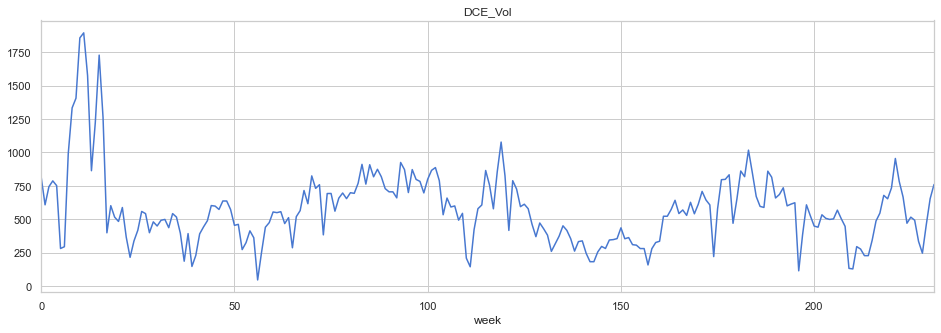

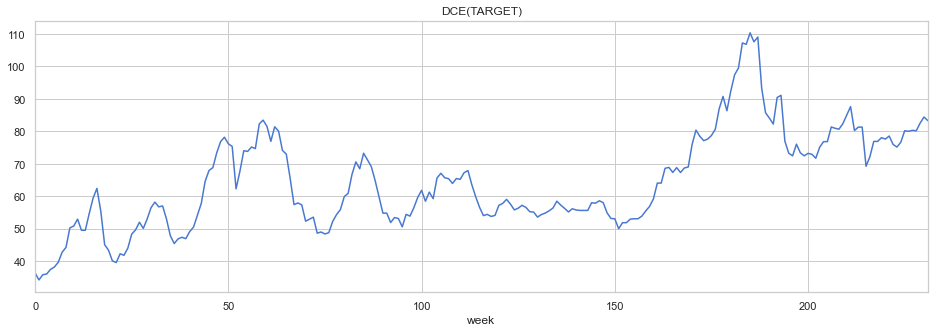

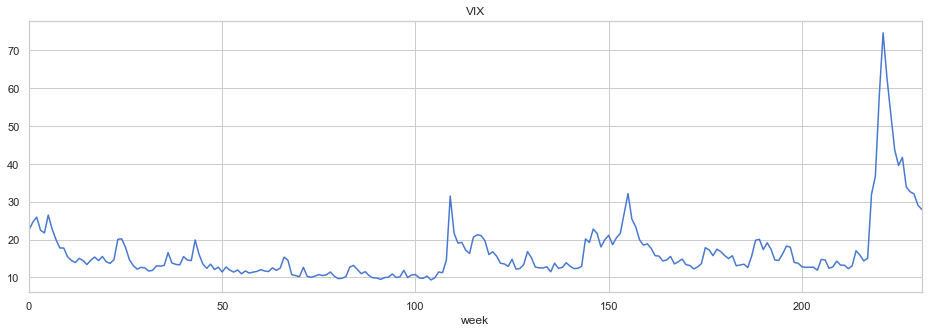

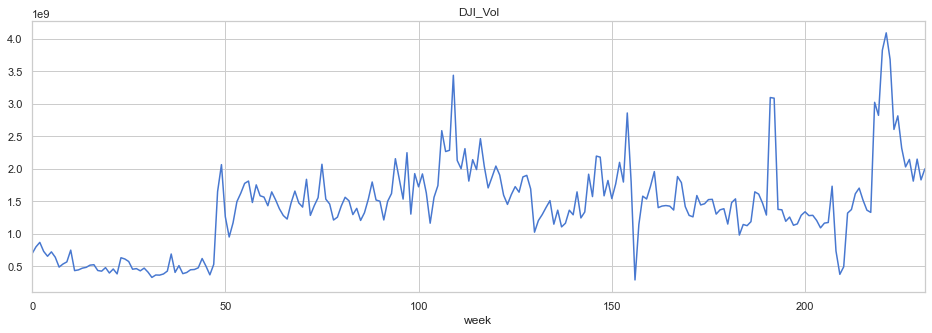

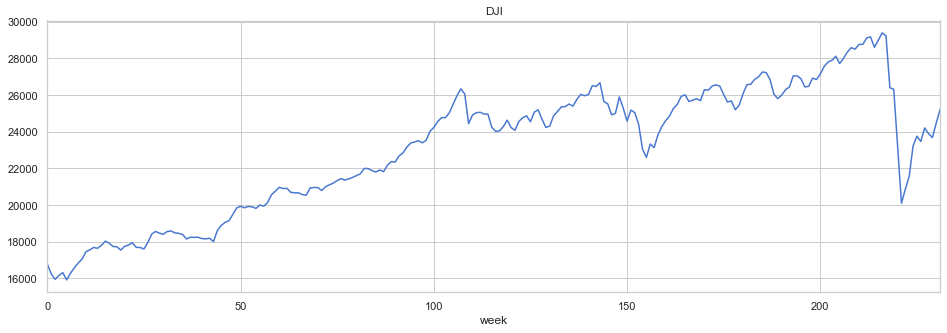

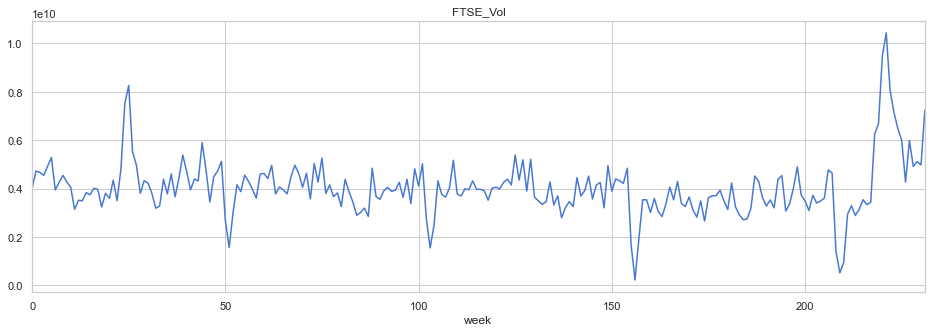

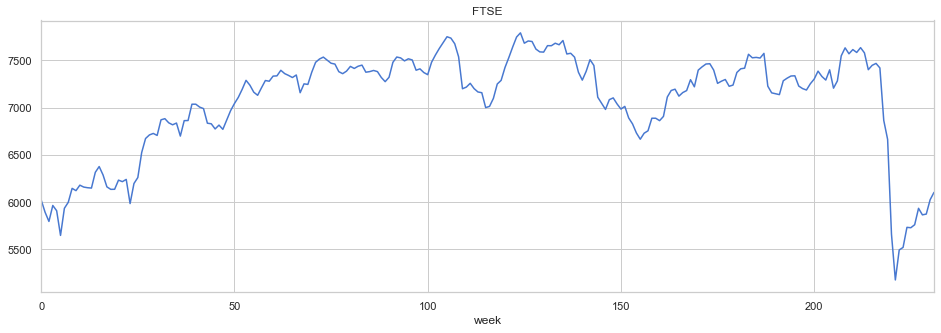

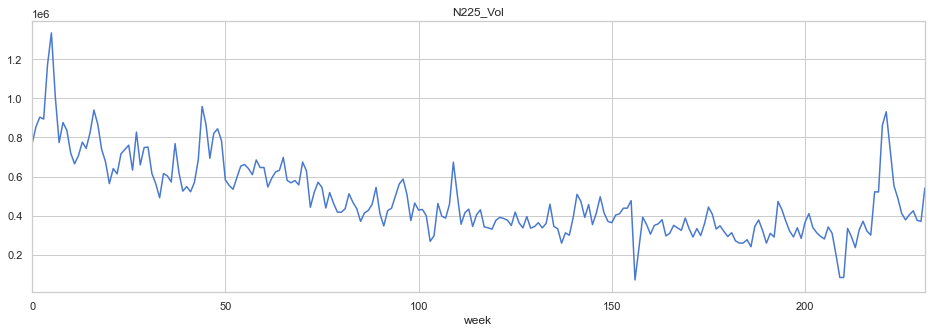

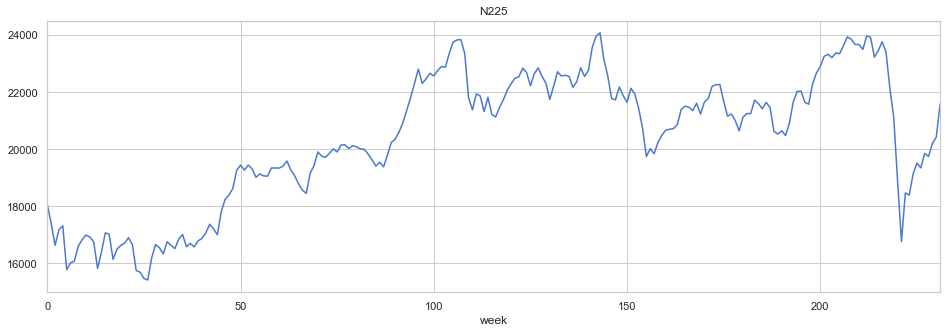

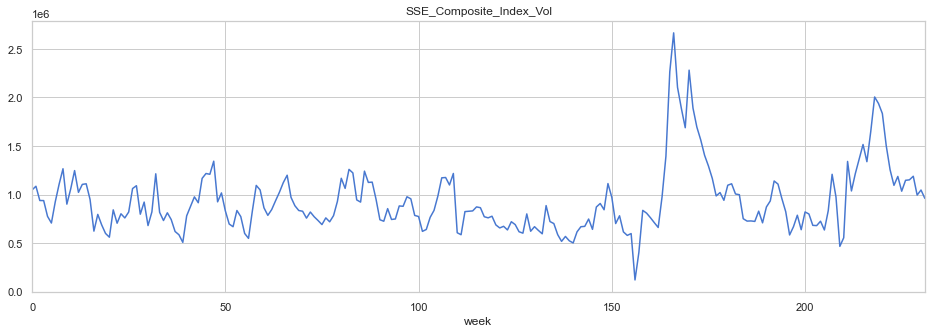

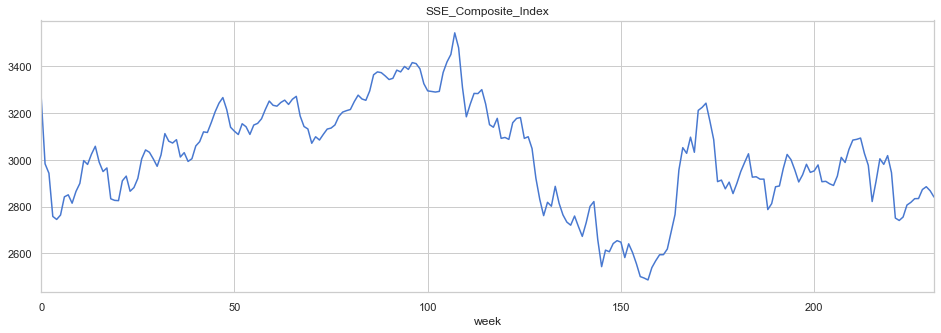

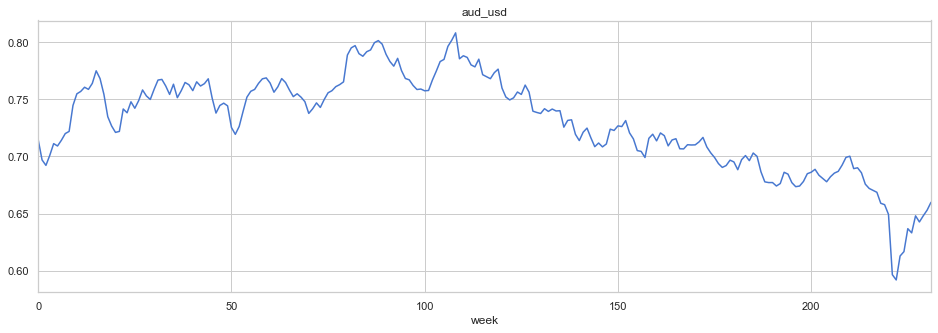

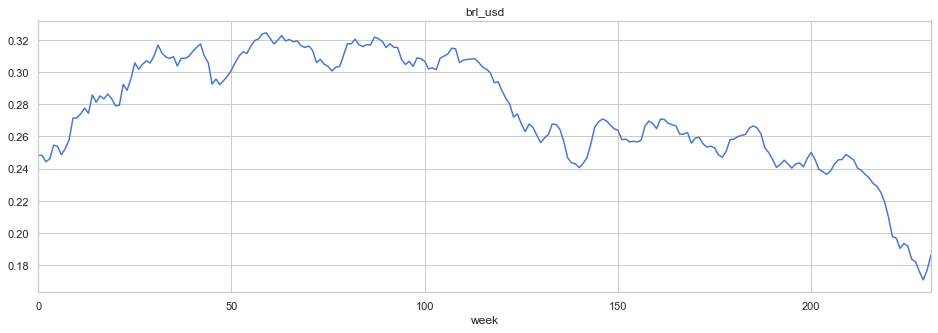

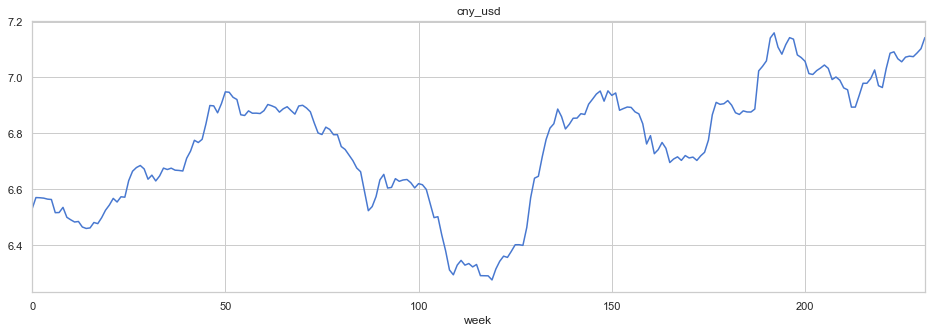

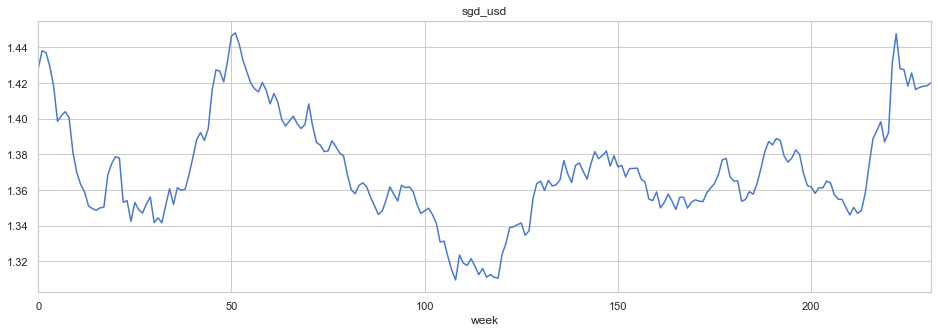

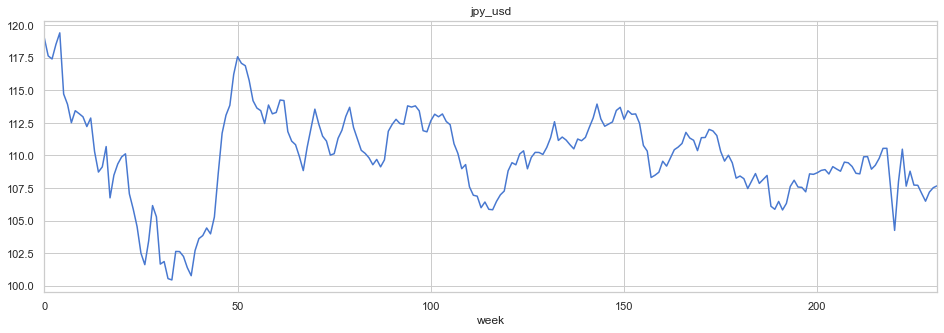

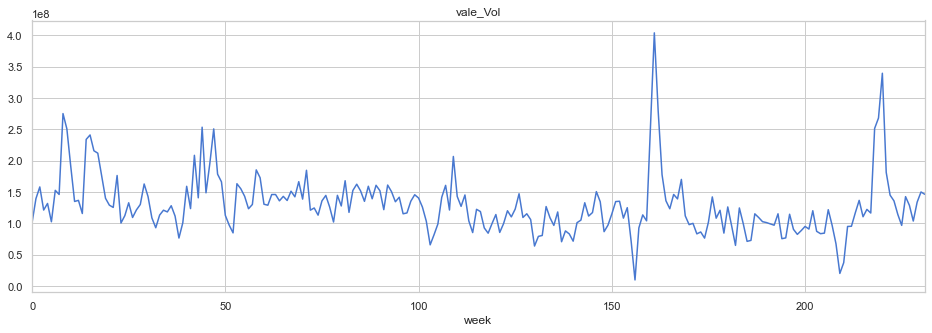

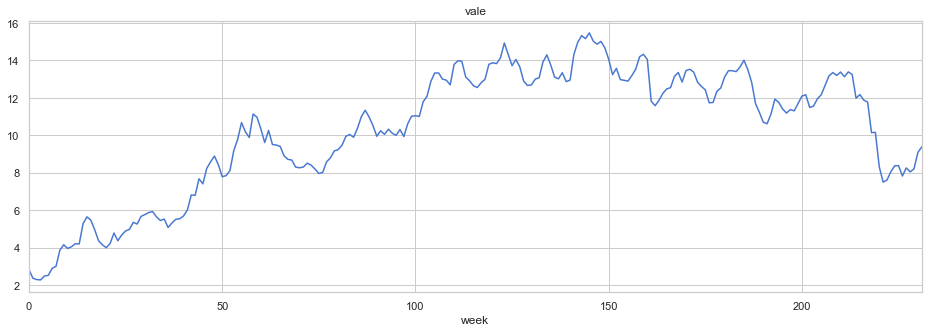

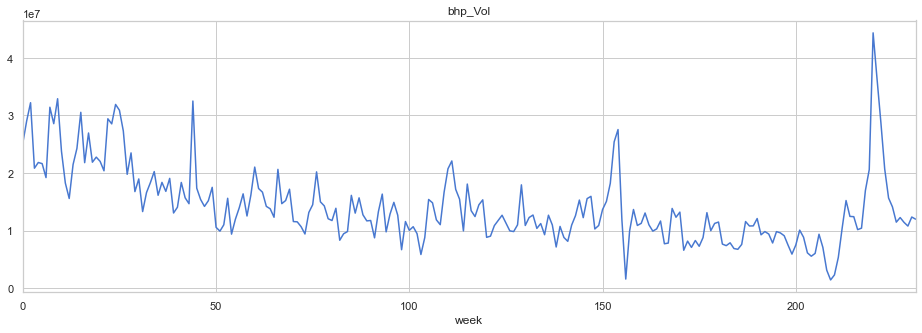

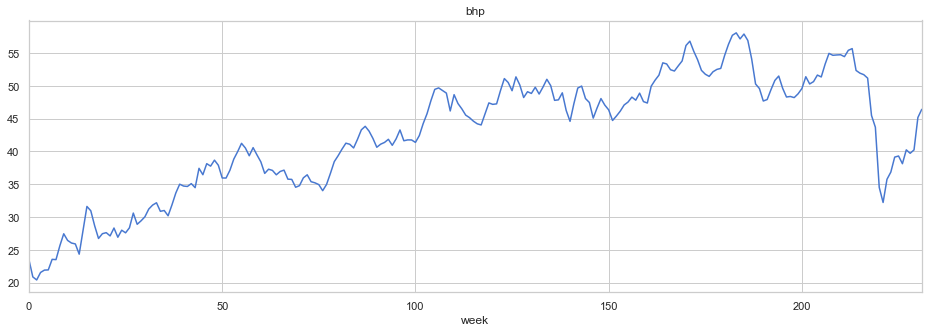

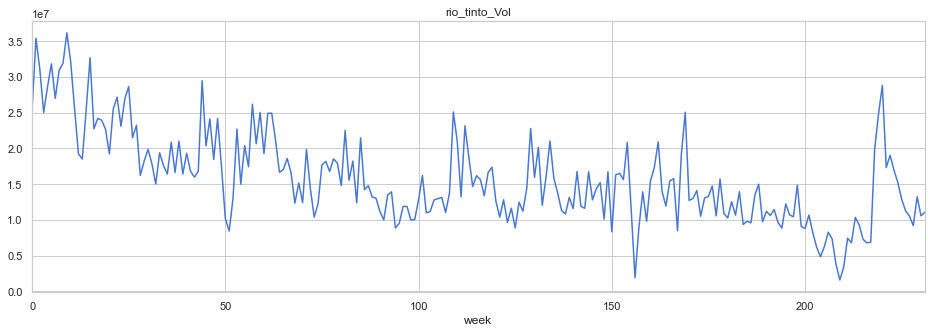

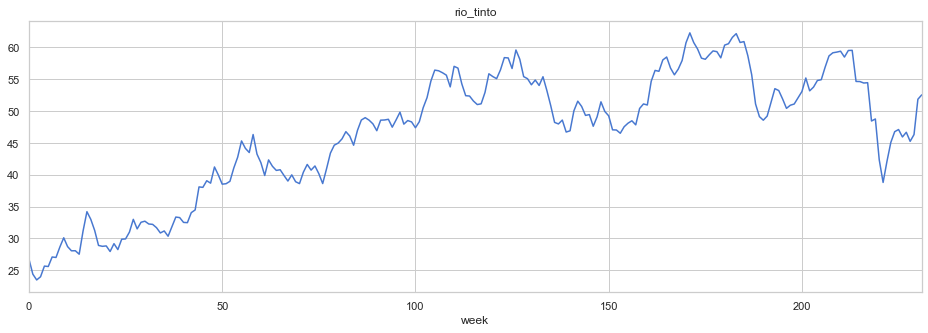

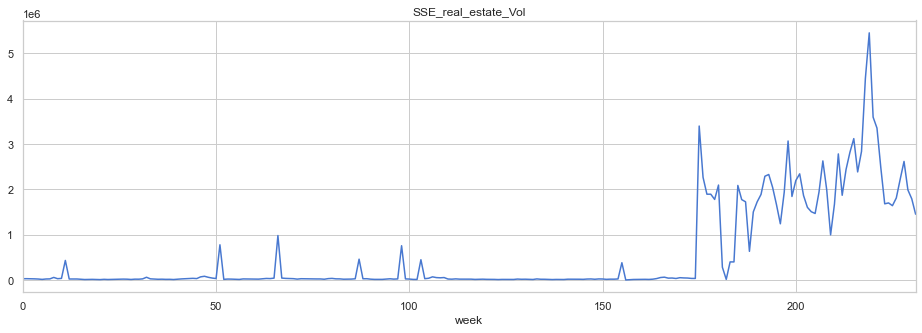

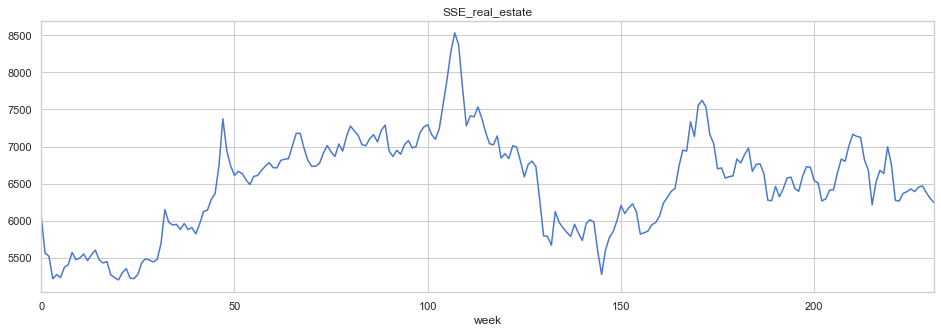

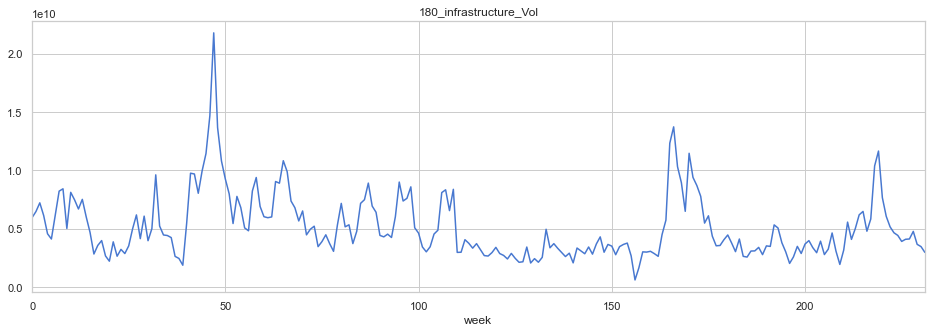

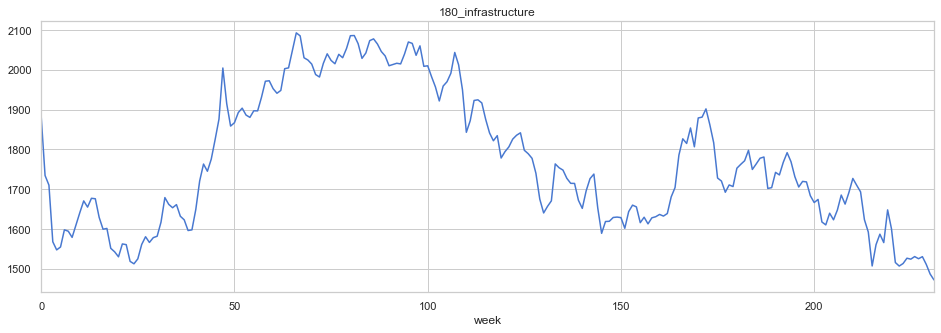

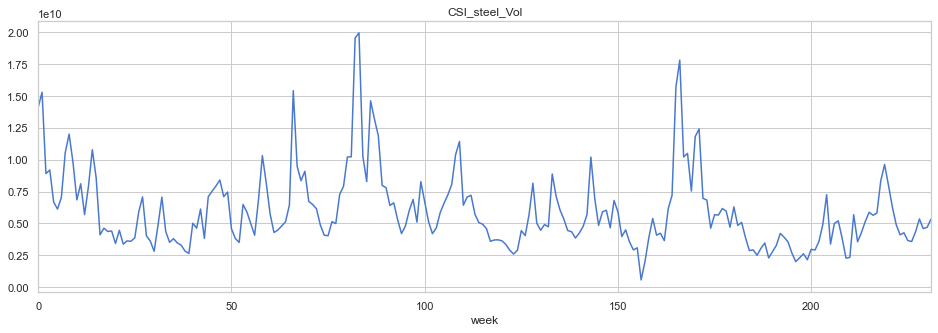

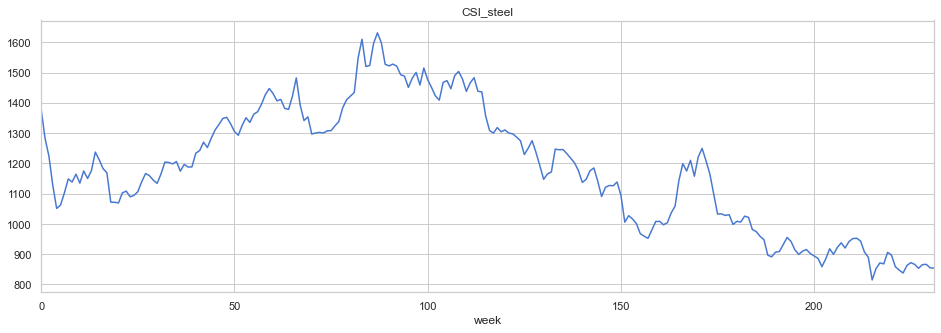

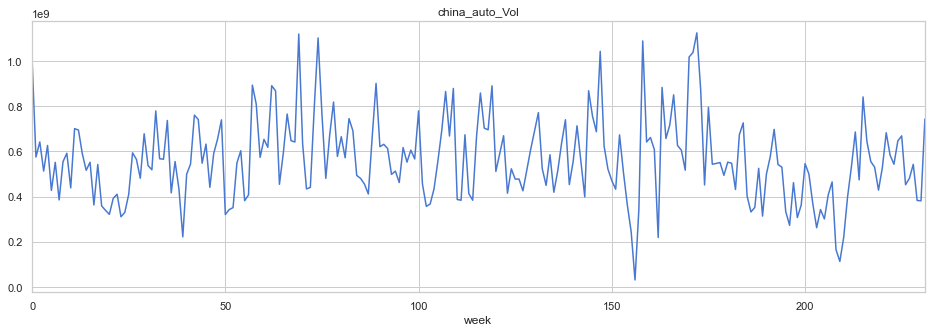

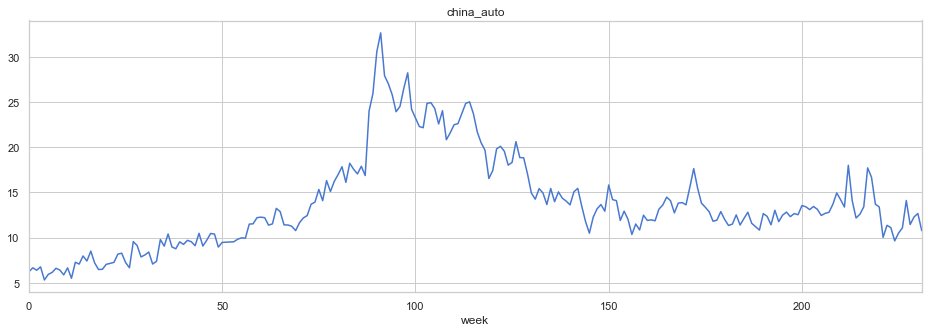

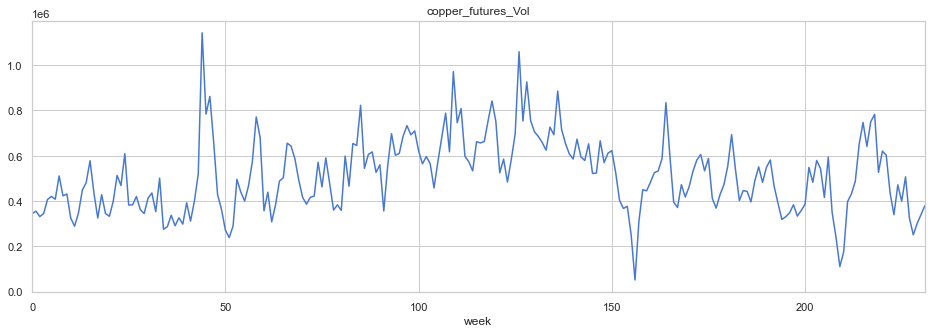

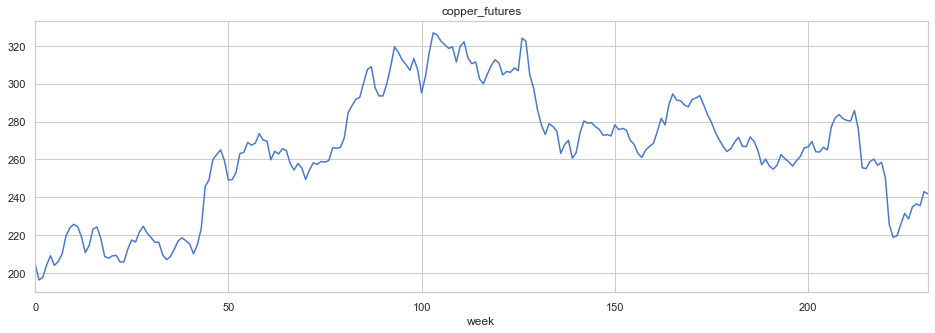

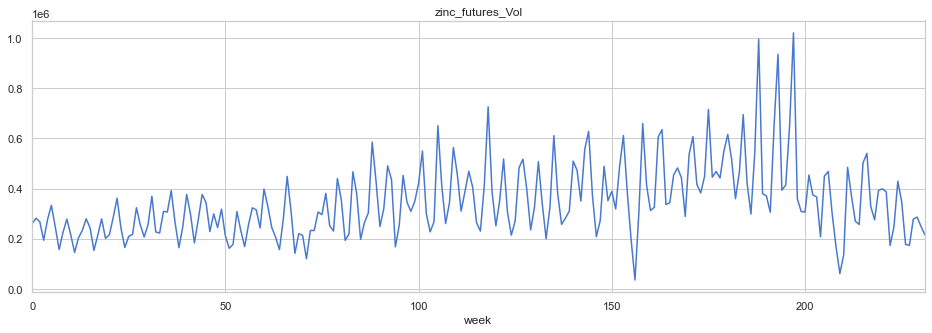

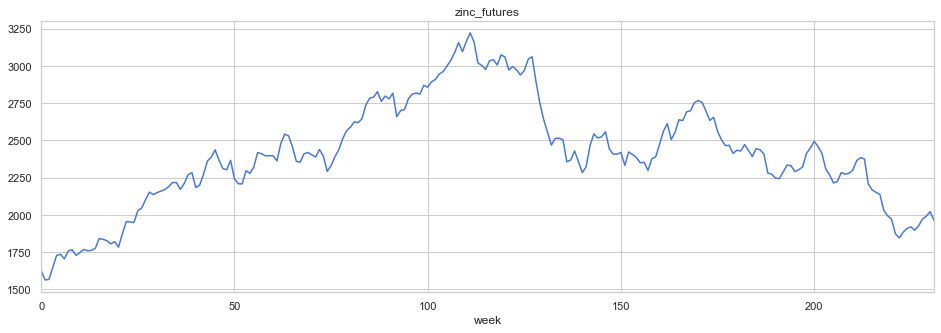

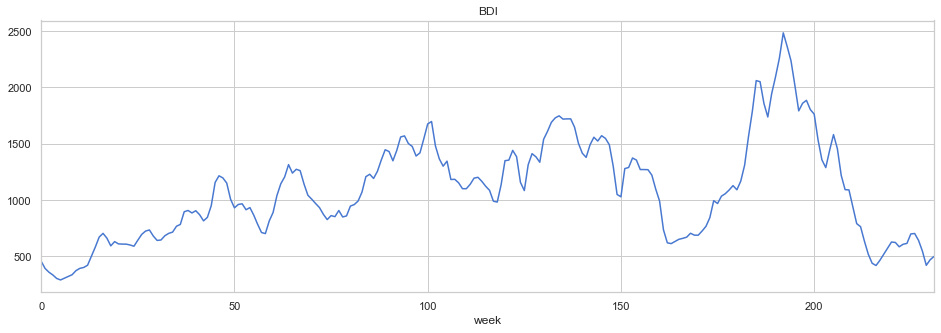

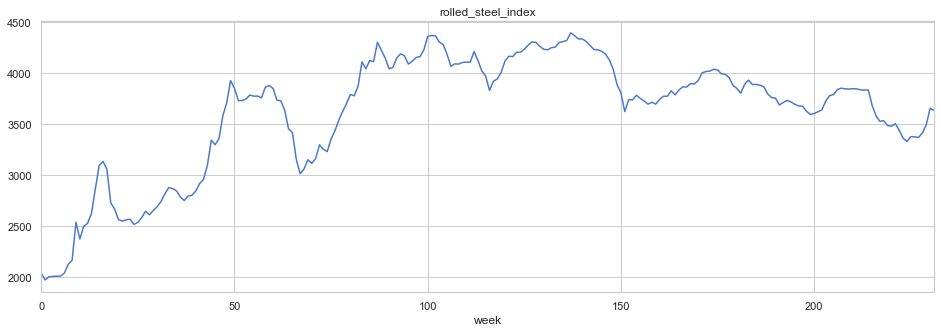

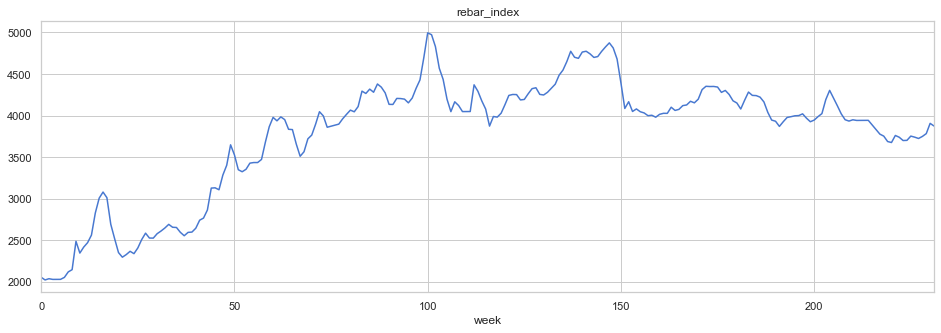

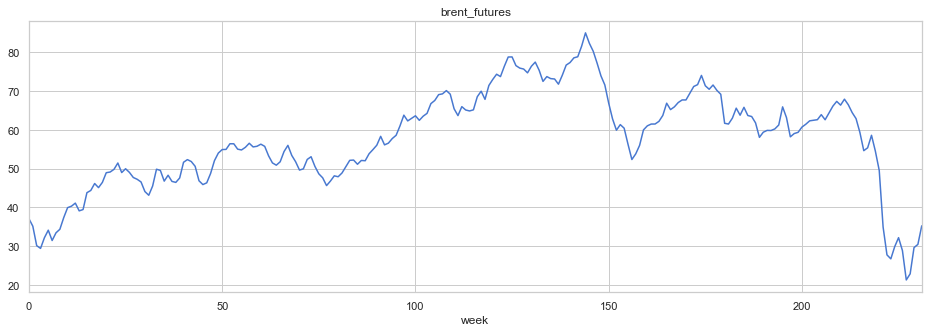

In [5]:
for each in df.columns[3:]:
    fig, ax = plt.subplots()
    title = each
    xlabel = "week"
    ax = df[each].plot(figsize=(16,5),title=title)
    ax.autoscale(axis='x', tight=True)
    ax.set(xlabel=xlabel);

# Create Exponential Moving Average (EMA) for feature transformation

To transform the features by calculating the percentage deviation of feature value from its EMAF, 1.) for standardizing the features of different scales and ii.) reflecting the relative percentagae deviation of feature value from a reference EMA. 

In [6]:
# a function to create EMA

def ema_dev(df, selected, span):
    '''
    input: dataframe, selected features and span
    return: features of EMA and features of % difference between EMA
    '''
    for each in selected:
        #df[each+"_"+str(span)+"EMA"] = df[each].ewm(span=span).mean()
        df[each+"_"+str(span)+"EMA"+"_%"] = (df[each]-df[each].ewm(span=span).mean())/df[each].ewm(span=span).mean()
 

In [7]:
df_EMA20 = df.copy()

In [8]:
selected = df_EMA20.columns[3:]  #skip the year, month & week
selected

Index(['DCE_Vol', 'DCE(TARGET)', 'VIX', 'DJI_Vol', 'DJI', 'FTSE_Vol', 'FTSE',
       'N225_Vol', 'N225', 'SSE_Composite_Index_Vol', 'SSE_Composite_Index',
       'aud_usd', 'brl_usd', 'cny_usd', 'sgd_usd', 'jpy_usd', 'vale_Vol',
       'vale', 'bhp_Vol', 'bhp', 'rio_tinto_Vol', 'rio_tinto',
       'SSE_real_estate_Vol', 'SSE_real_estate', '180_infrastructure_Vol',
       '180_infrastructure', 'CSI_steel_Vol', 'CSI_steel', 'china_auto_Vol',
       'china_auto', 'copper_futures_Vol', 'copper_futures',
       'zinc_futures_Vol', 'zinc_futures', 'BDI', 'rolled_steel_index',
       'rebar_index', 'brent_futures'],
      dtype='object')

In [9]:
# create the EMA
ema_dev(df_EMA20, selected, 20)

In [10]:
# drop the 2016 data, after creating EMA

df_EMA20 = df_EMA20.drop(selected, axis=1)
df_EMA20 = df_EMA20[df['year']!=2016]

In [11]:
print(df_EMA20.shape)
print()
df_EMA20.head(2)

(180, 41)



year month  week  DCE_Vol_20EMA_%  DCE(TARGET)_20EMA_%  VIX_20EMA_%  \
52  2017   Jan     1        -0.435848            -0.015538    -0.123118   
53  2017   Jan     2        -0.306693             0.062826    -0.147287   

    DJI_Vol_20EMA_%  DJI_20EMA_%  FTSE_Vol_20EMA_%  FTSE_20EMA_%  \
52         0.409348     0.050131         -0.245945      0.044765   
53         0.674770     0.044017          0.041196      0.052677   

    N225_Vol_20EMA_%  N225_20EMA_%  SSE_Composite_Index_Vol_20EMA_%  \
52         -0.209315      0.081691                        -0.256326   
53         -0.109536      0.066838                        -0.063874   

    SSE_Composite_Index_20EMA_%  aud_usd_20EMA_%  brl_usd_20EMA_%  \
52                     0.012344        -0.025677         0.023787   
53                     0.007430        -0.007359         0.028948   

    cny_usd_20EMA_%  sgd_usd_20EMA_%  jpy_usd_20EMA_%  vale_Vol_20EMA_%  \
52         0.017542         0.025567         0.062111          -0.41797   
53         0.014789         0.017120         0.046658           0.10823   

    vale_20EMA_%  bhp_Vol_20EMA_%  bhp_20EMA_%  rio_tinto_Vol_20EMA_%  \
52      0.140297        -0.319606     0.058562              -0.269404   
53      0.256368        -0.032282     0.095760               0.240133   

    rio_tinto_20EMA_%  SSE_real_estate_Vol_20EMA_%  SSE_real_estate_20EMA_%  \
52           0.075278                    -0.838742                  0.04389   
53           0.118762                    -0.757019                  0.02796   

    180_infrastructure_Vol_20EMA_%  180_infrastructure_20EMA_%  \
52                       -0.383984                    0.064102   
53                       -0.110933                    0.048936   

    CSI_steel_Vol_20EMA_%  CSI_steel_20EMA_%  china_auto_Vol_20EMA_%  \
52              -0.346829           0.043899               -0.318589   
53               0.182454           0.057133                0.058527   

    china_auto_20EMA_%  copper_futures_Vol_20EMA_%  copper_futures_20EMA_%  \
52            0.023238                   -0.351593                0.059979   
53            0.022500                    0.099668                0.090886   

    zinc_futures_Vol_20EMA_%  zinc_futures_20EMA_%  BDI_20EMA_%  \
52                 -0.304355             -0.016131     0.035611   
53                  0.184926              0.021104    -0.018970   

    rolled_steel_index_20EMA_%  rebar_index_20EMA_%  brent_futures_20EMA_%  
52                    0.125611             0.086313               0.115759  
53                    0.116467             0.086059               0.103452

# Train/ Test Split

In [12]:
############################## use 20 week EMA version for the analysis ##############################

df_EMA = df_EMA20.copy()  

In [13]:
# hold some data for testing

nobs = 30
train, test = df_EMA[0:-nobs], df_EMA[-nobs:]

print('Shape of train: ', train.shape)
print('Shape of test: ', test.shape)

Shape of train:  (150, 41)
Shape of test:  (30, 41)


# Visualize the data again after transformation

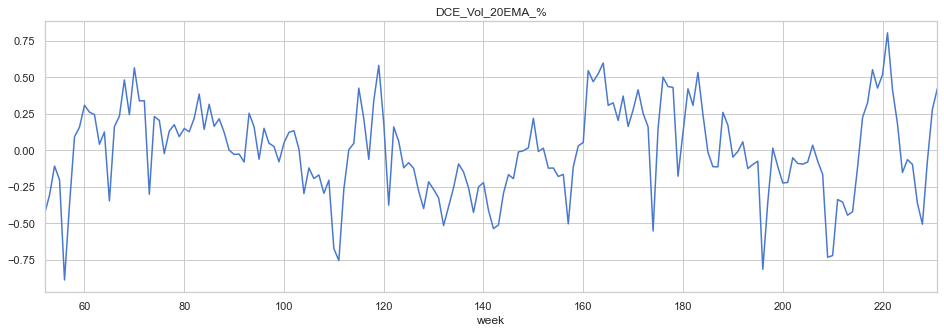

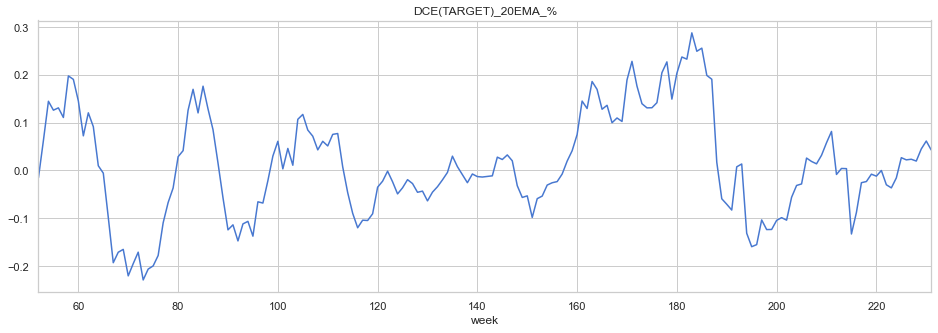

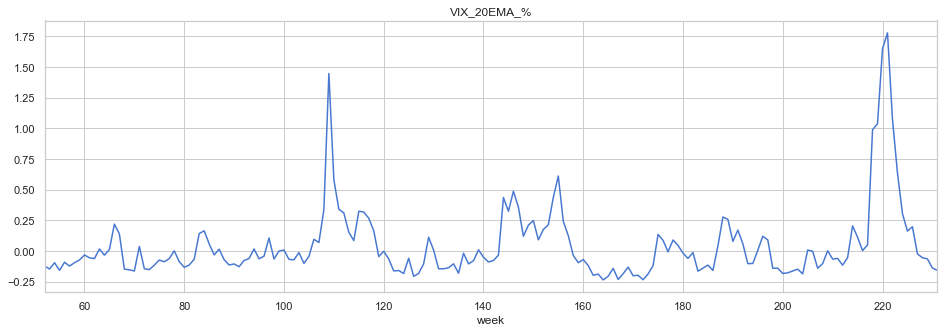

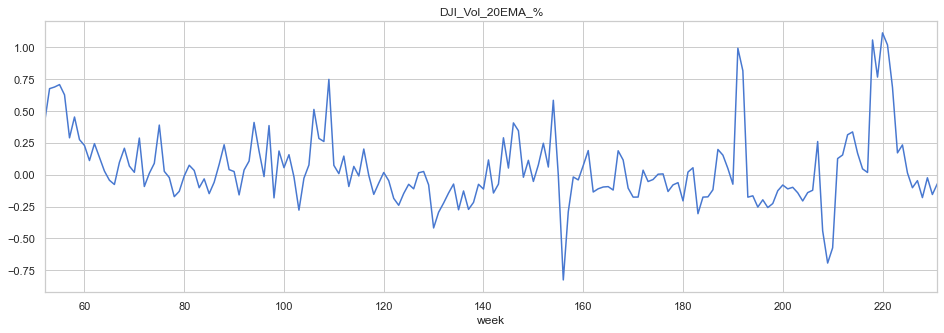

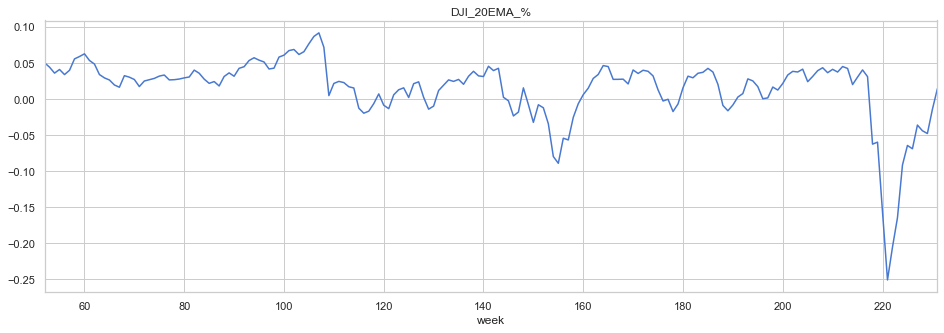

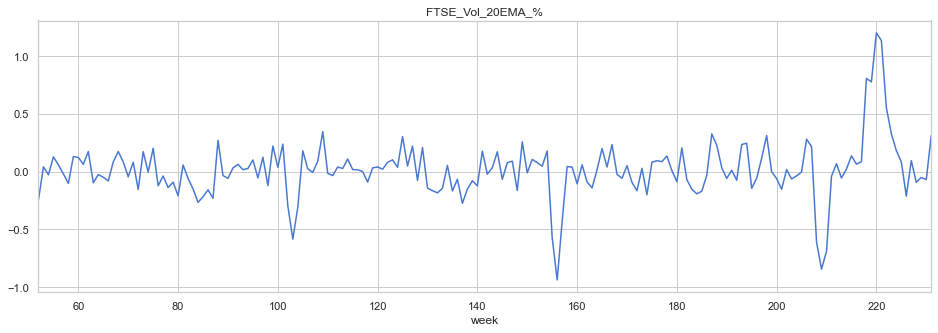

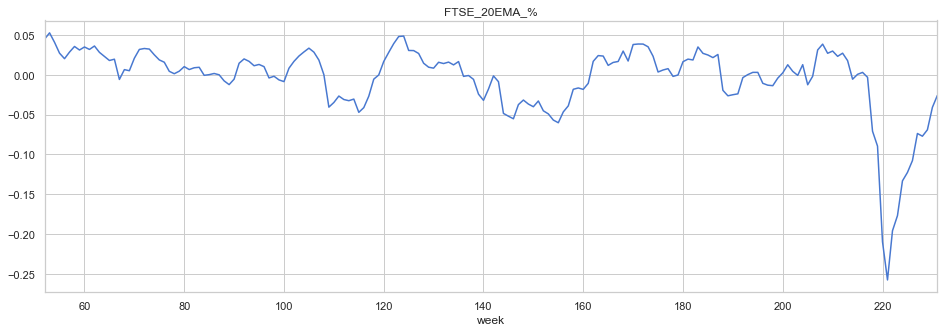

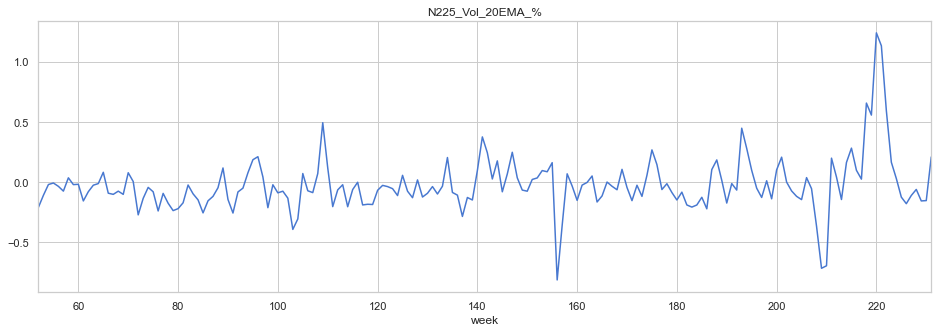

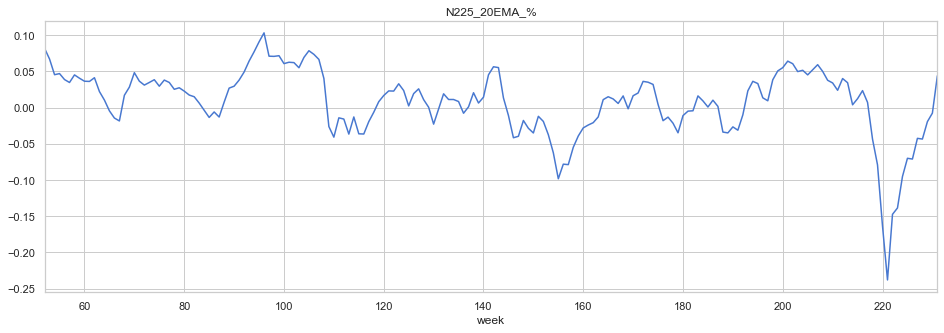

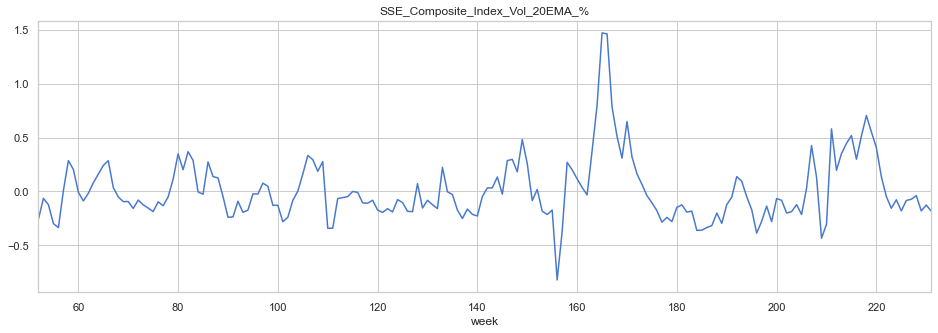

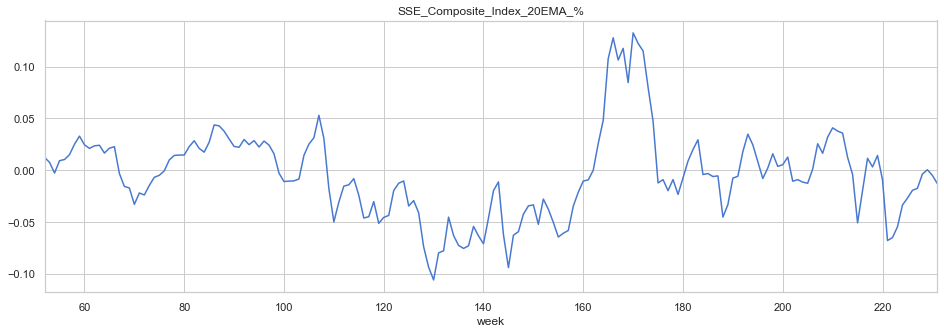

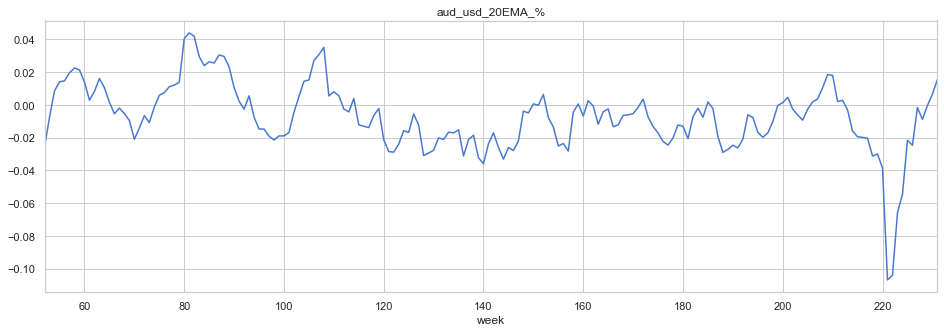

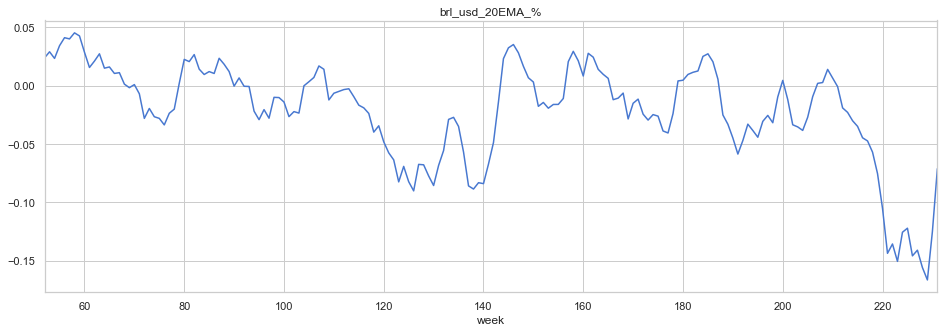

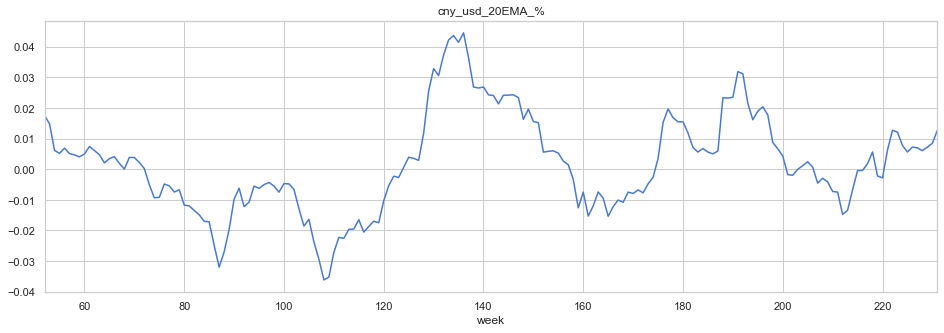

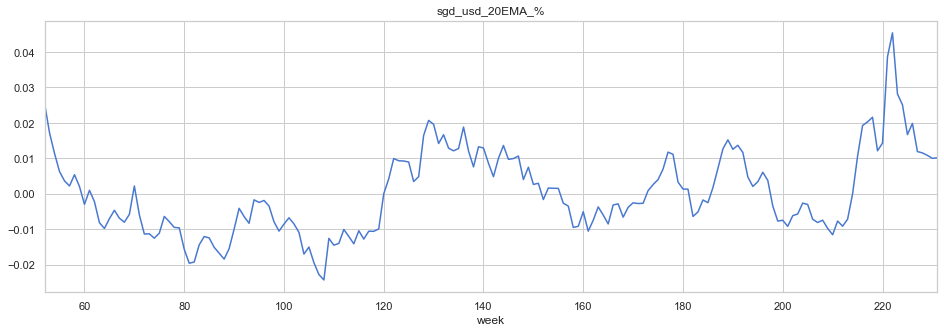

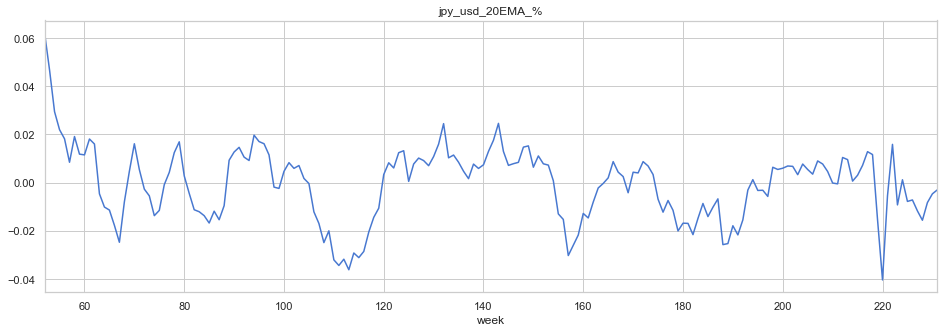

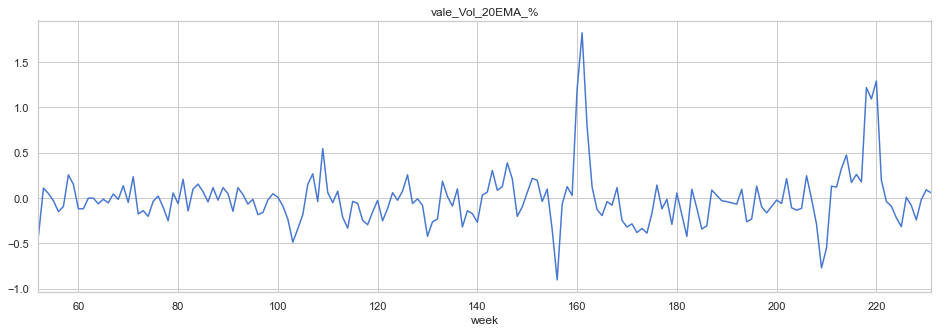

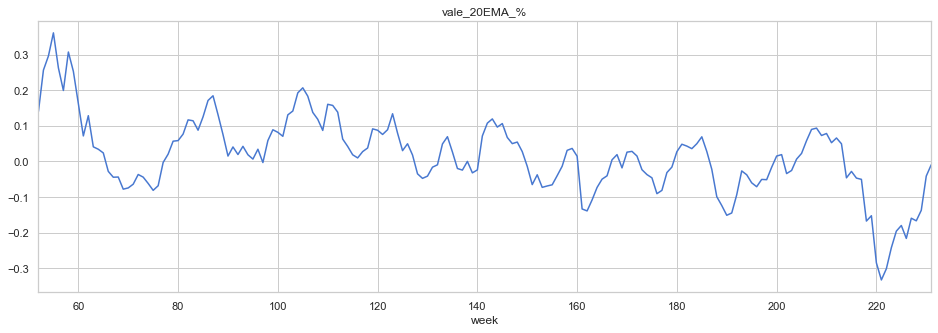

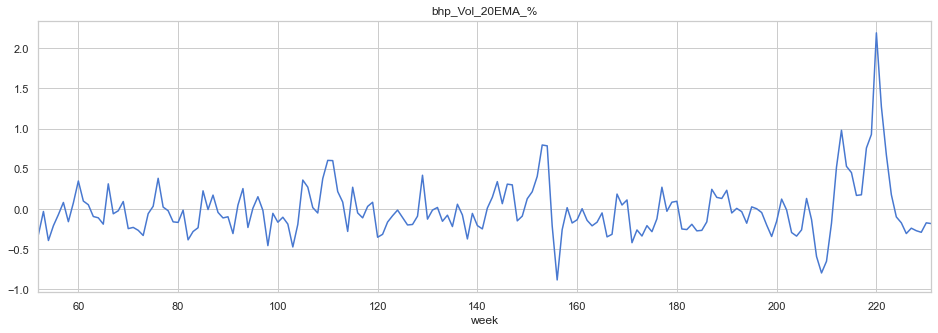

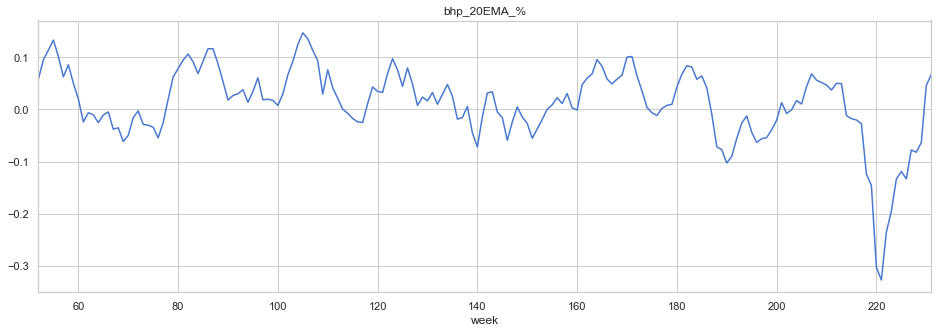

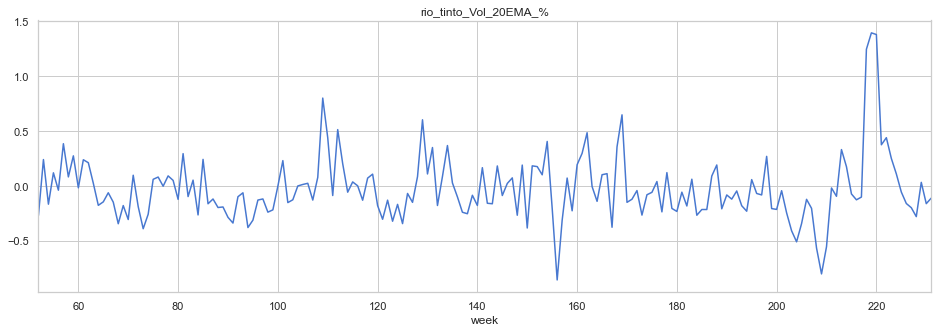

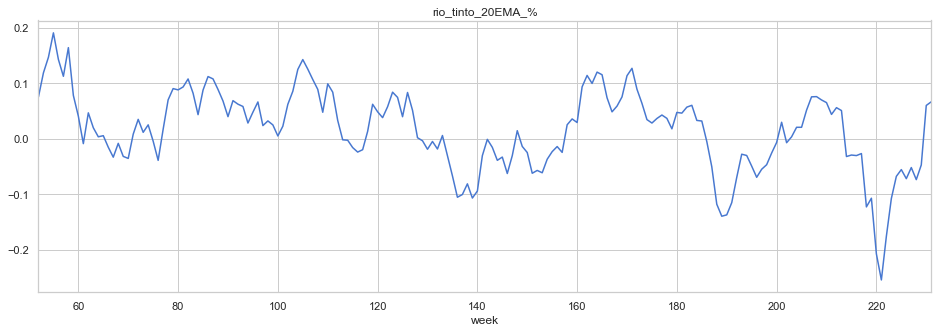

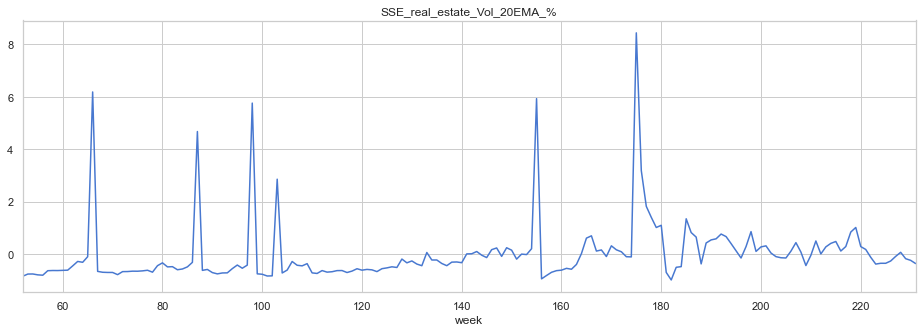

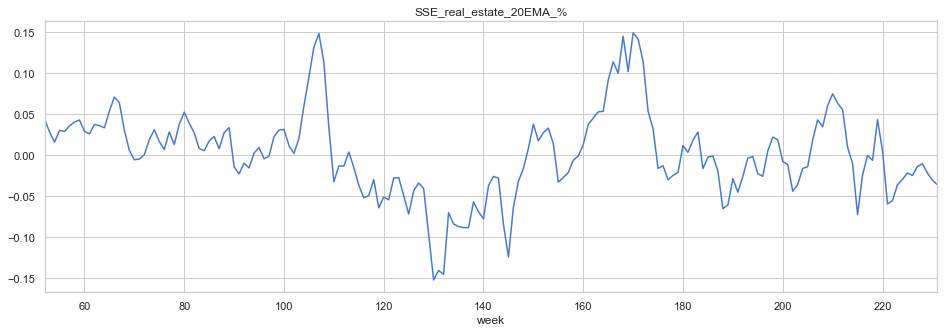

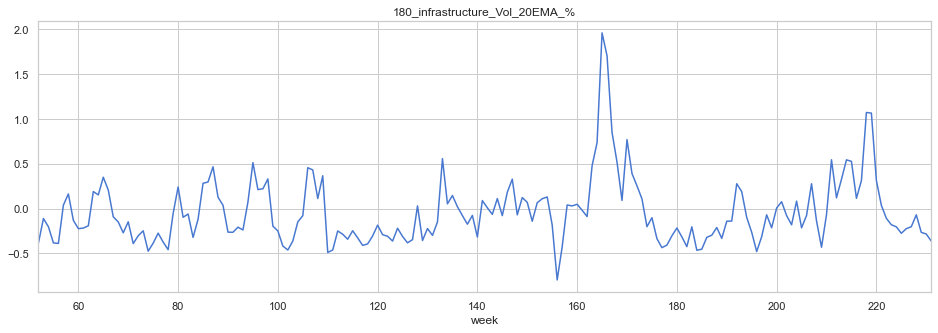

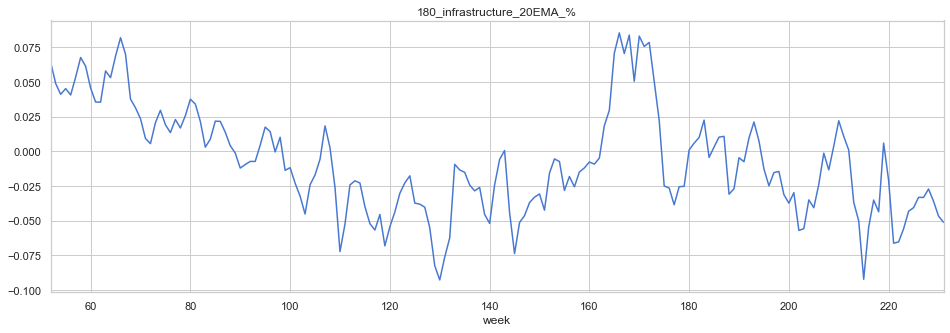

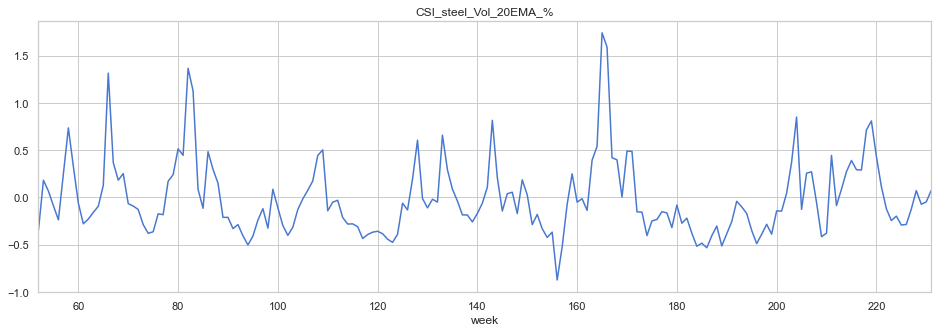

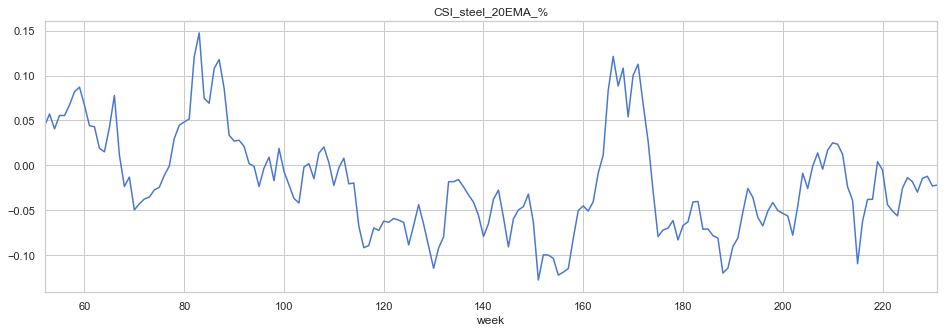

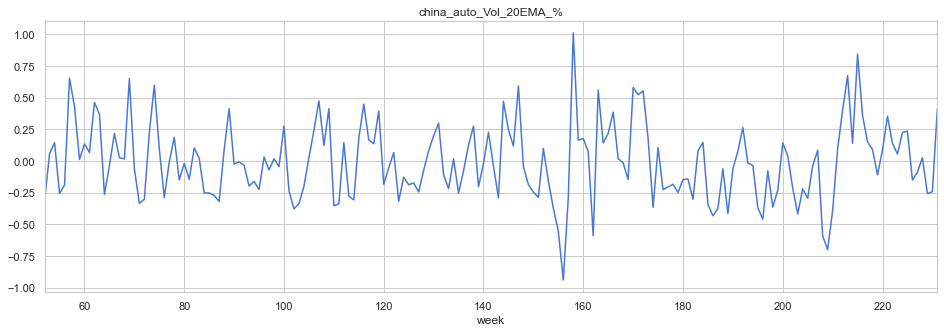

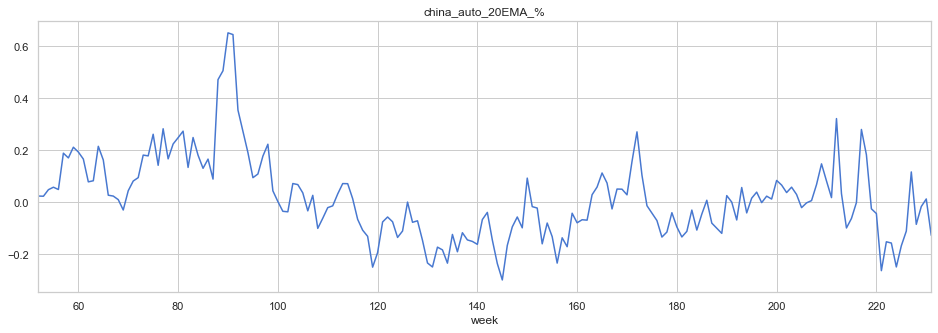

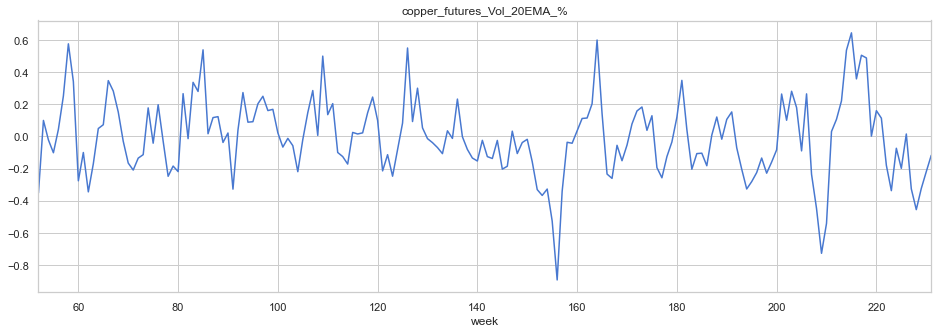

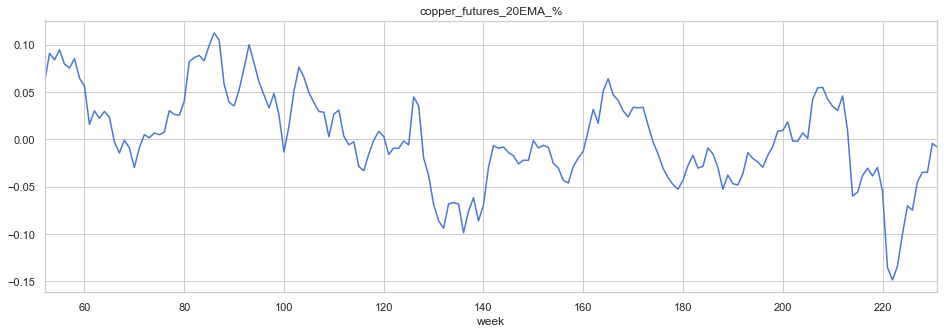

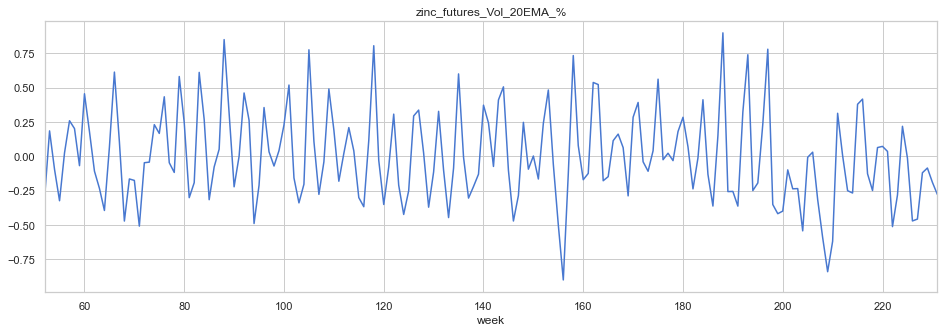

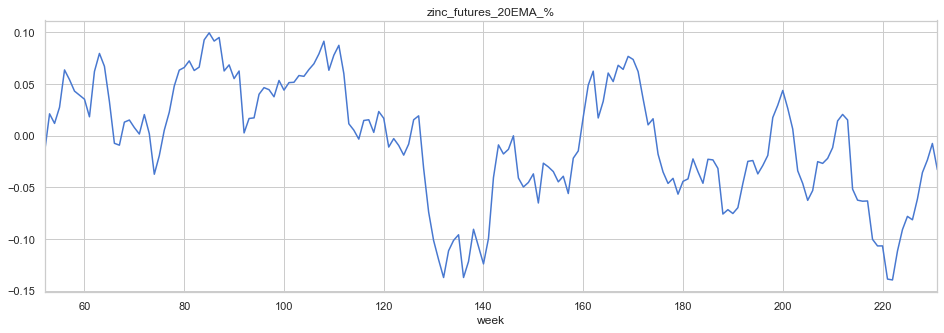

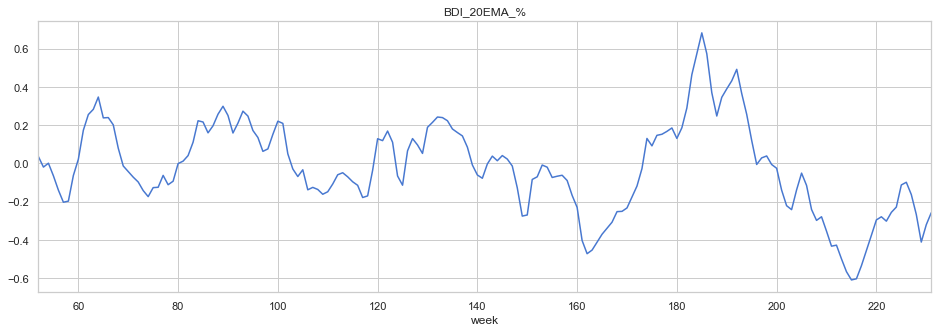

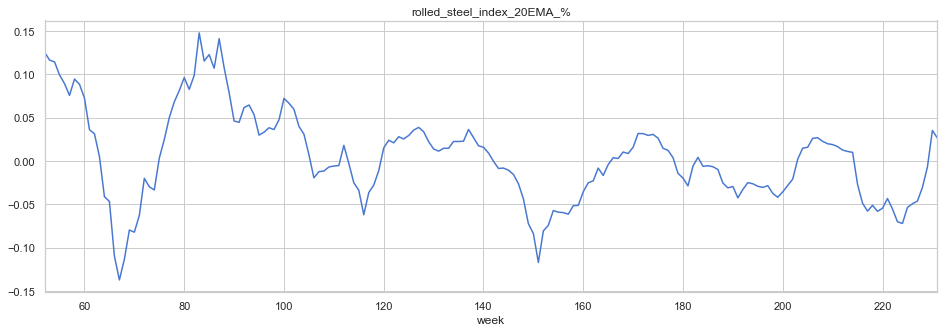

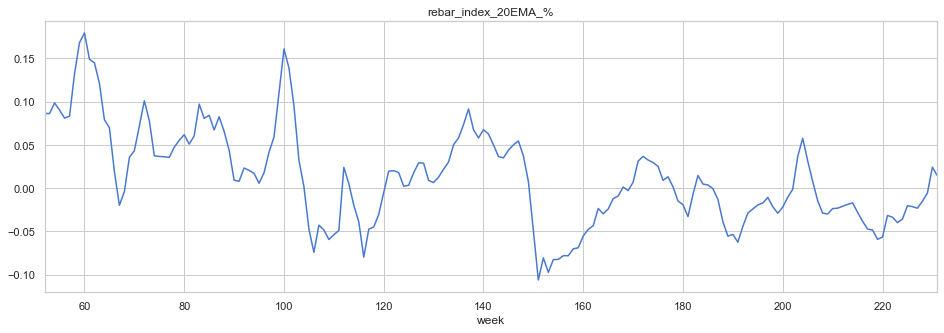

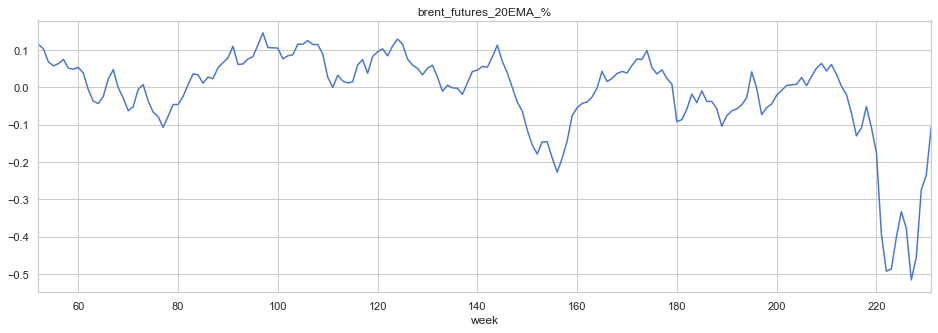

In [14]:
for each in df_EMA.columns[3:]:
    fig, ax = plt.subplots()
    title = each
    xlabel = "week"
    ax = df_EMA[each].plot(figsize=(16,5),title=title)
    ax.autoscale(axis='x', tight=True)
    ax.set(xlabel=xlabel);

# Test for Stationarity

In [15]:
# define a function for ADF (Augmented Dickey Fuller) Test
# a difference stationarity test

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    #print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags used', '# Observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    #print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        #print("Strong evidence against the null hypothesis")
        #print("Reject the null hypothesis")
        #print("Data has no unit root and is stationary")
        res = "stationary"
    else:
        #print("Weak evidence against the null hypothesis")
        #print("Fail to reject the null hypothesis")
        #print("Data has a unit root and is non-stationary")
        res = "non-stationary"
    return res

In [16]:
# excluding "year", "month" and "week"

picked = train.columns[3:] 

In [17]:
# ADF (Augmented Dickey Fuller) Test

adf_results = {}

for each in picked:
    adf_results[each] = adf_test(train[each], title=each)

adf_results 

{'DCE_Vol_20EMA_%': 'stationary',
 'DCE(TARGET)_20EMA_%': 'stationary',
 'VIX_20EMA_%': 'stationary',
 'DJI_Vol_20EMA_%': 'stationary',
 'DJI_20EMA_%': 'stationary',
 'FTSE_Vol_20EMA_%': 'stationary',
 'FTSE_20EMA_%': 'stationary',
 'N225_Vol_20EMA_%': 'stationary',
 'N225_20EMA_%': 'stationary',
 'SSE_Composite_Index_Vol_20EMA_%': 'stationary',
 'SSE_Composite_Index_20EMA_%': 'stationary',
 'aud_usd_20EMA_%': 'stationary',
 'brl_usd_20EMA_%': 'stationary',
 'cny_usd_20EMA_%': 'non-stationary',
 'sgd_usd_20EMA_%': 'non-stationary',
 'jpy_usd_20EMA_%': 'stationary',
 'vale_Vol_20EMA_%': 'stationary',
 'vale_20EMA_%': 'stationary',
 'bhp_Vol_20EMA_%': 'stationary',
 'bhp_20EMA_%': 'stationary',
 'rio_tinto_Vol_20EMA_%': 'stationary',
 'rio_tinto_20EMA_%': 'stationary',
 'SSE_real_estate_Vol_20EMA_%': 'stationary',
 'SSE_real_estate_20EMA_%': 'stationary',
 '180_infrastructure_Vol_20EMA_%': 'stationary',
 '180_infrastructure_20EMA_%': 'non-stationary',
 'CSI_steel_Vol_20EMA_%': 'stationar

# Transformation for Stationary

In [18]:
# transform data to stationary by 1st difference

temp = df_EMA[picked].diff().dropna()
temp.shape

(179, 38)

In [19]:
transformed_col = []

for each in picked:
    transformed_col.append(each+'_1d')
    
col = ["year", "month", "week"] + transformed_col

In [20]:
# remove the 1st row for 1st difference

df_EMA_trans = df_EMA.iloc[1:][["year", "month", "week"]]

In [21]:
df_EMA_trans = pd.concat([df_EMA_trans, temp], axis=1)
df_EMA_trans.columns = col

In [22]:
# test again for stationary after 1st difference

adf_results = {}

for each in df_EMA_trans.columns[3:]:
    adf_results[each] = adf_test(df_EMA_trans[each], title=each)

adf_results 

{'DCE_Vol_20EMA_%_1d': 'stationary',
 'DCE(TARGET)_20EMA_%_1d': 'stationary',
 'VIX_20EMA_%_1d': 'stationary',
 'DJI_Vol_20EMA_%_1d': 'stationary',
 'DJI_20EMA_%_1d': 'stationary',
 'FTSE_Vol_20EMA_%_1d': 'stationary',
 'FTSE_20EMA_%_1d': 'stationary',
 'N225_Vol_20EMA_%_1d': 'stationary',
 'N225_20EMA_%_1d': 'stationary',
 'SSE_Composite_Index_Vol_20EMA_%_1d': 'stationary',
 'SSE_Composite_Index_20EMA_%_1d': 'stationary',
 'aud_usd_20EMA_%_1d': 'stationary',
 'brl_usd_20EMA_%_1d': 'stationary',
 'cny_usd_20EMA_%_1d': 'stationary',
 'sgd_usd_20EMA_%_1d': 'stationary',
 'jpy_usd_20EMA_%_1d': 'stationary',
 'vale_Vol_20EMA_%_1d': 'stationary',
 'vale_20EMA_%_1d': 'stationary',
 'bhp_Vol_20EMA_%_1d': 'stationary',
 'bhp_20EMA_%_1d': 'stationary',
 'rio_tinto_Vol_20EMA_%_1d': 'stationary',
 'rio_tinto_20EMA_%_1d': 'stationary',
 'SSE_real_estate_Vol_20EMA_%_1d': 'stationary',
 'SSE_real_estate_20EMA_%_1d': 'stationary',
 '180_infrastructure_Vol_20EMA_%_1d': 'stationary',
 '180_infrastructu

In [23]:
# check for any non-stationary feature, return only when there exists non-stationary feature

for key, res in adf_results.items():
    if res == "non-stationary":
        print('non-stationary: ', key)

# Check for Seasonality

Check for any seasonality within the data after transformation.

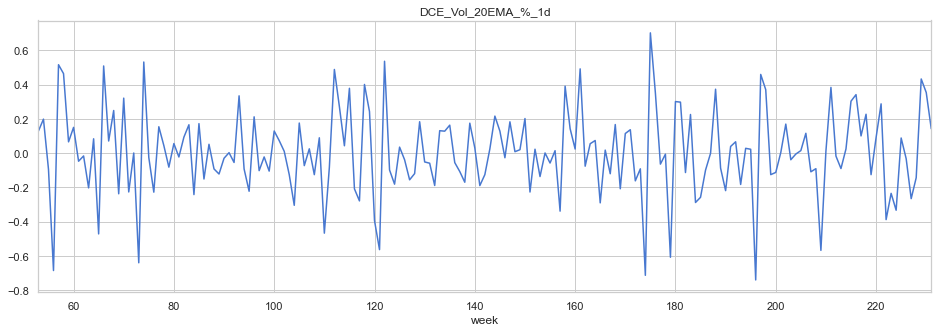

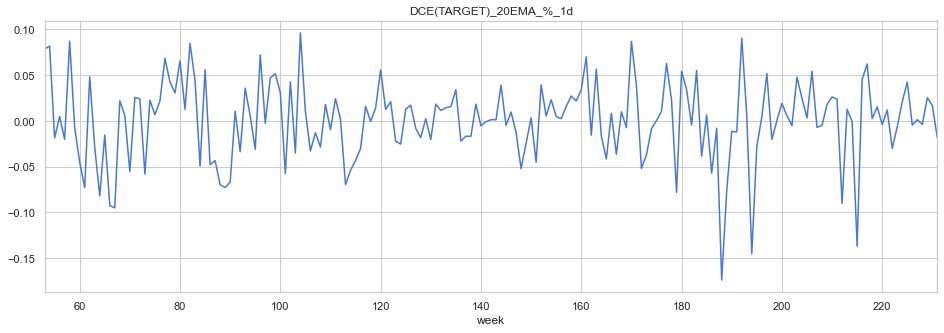

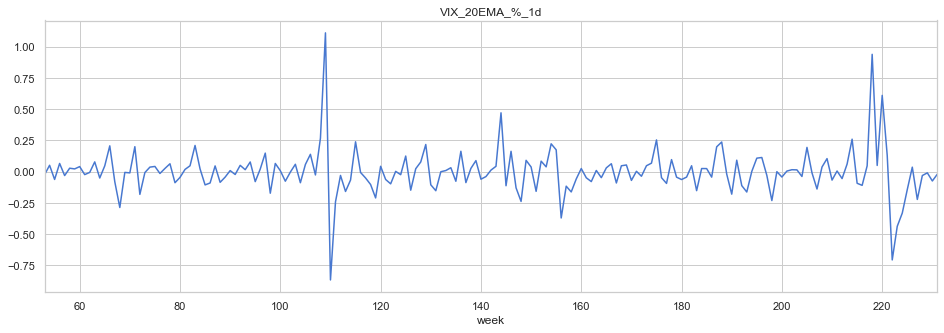

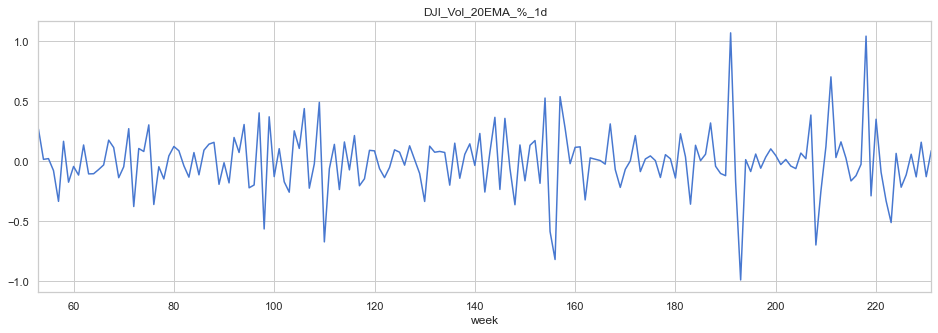

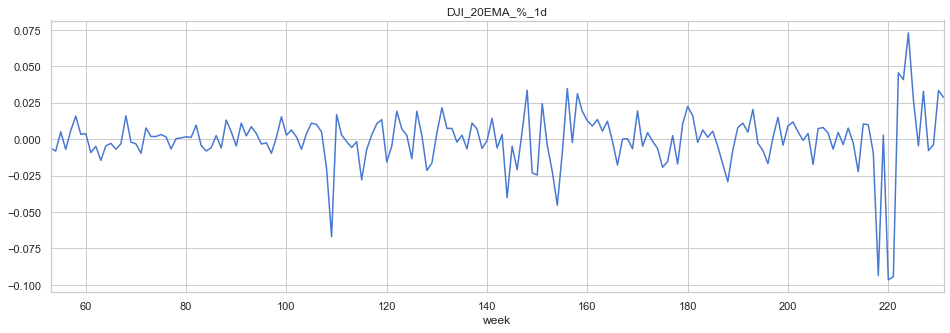

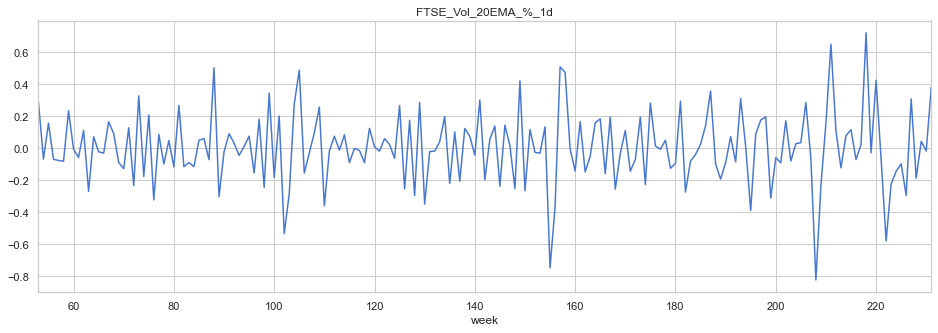

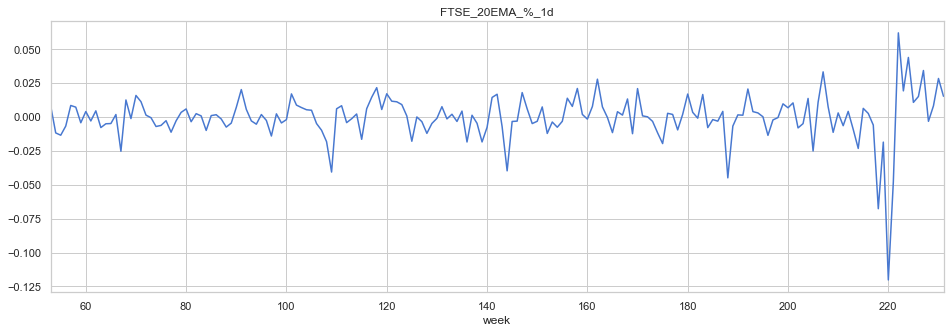

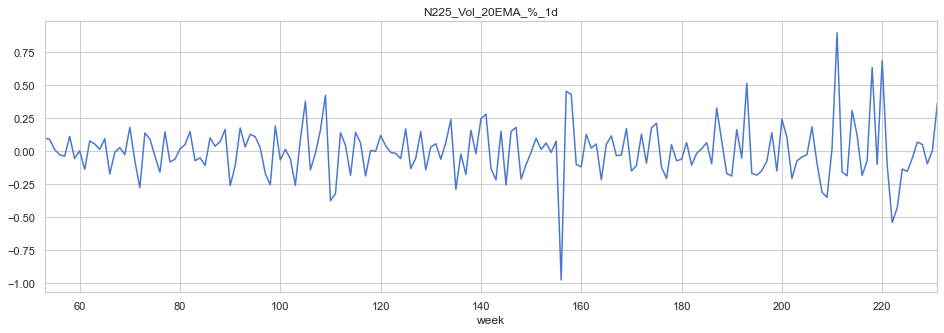

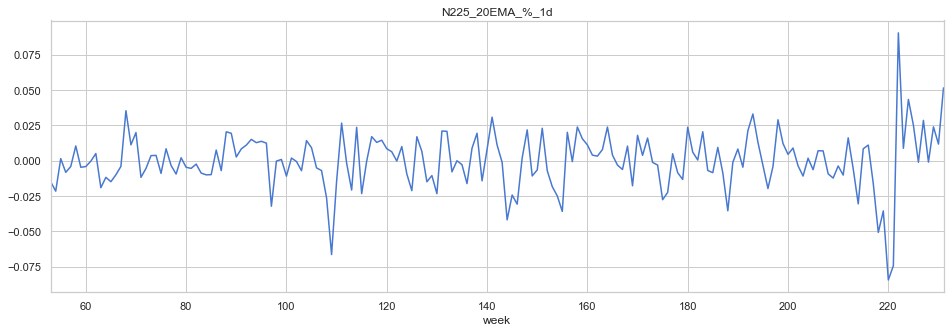

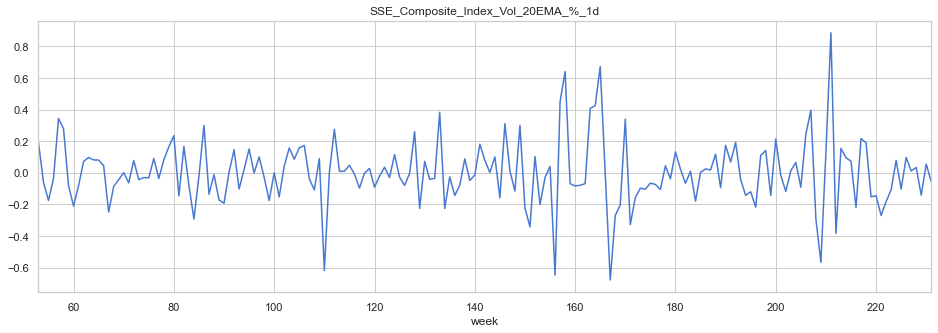

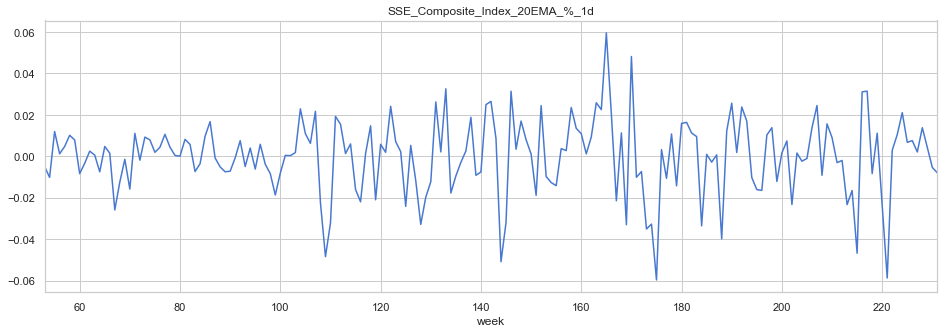

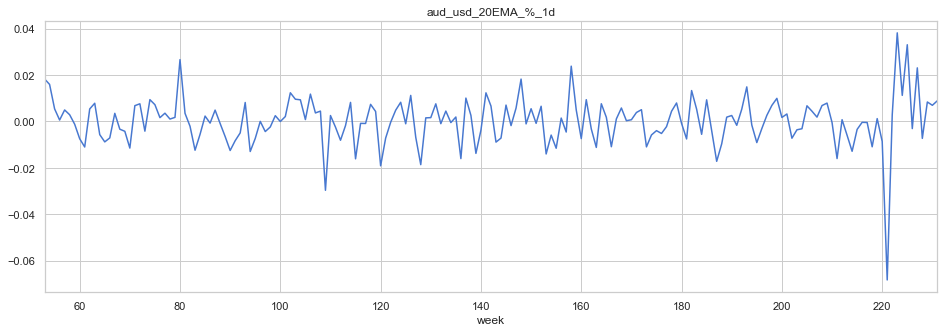

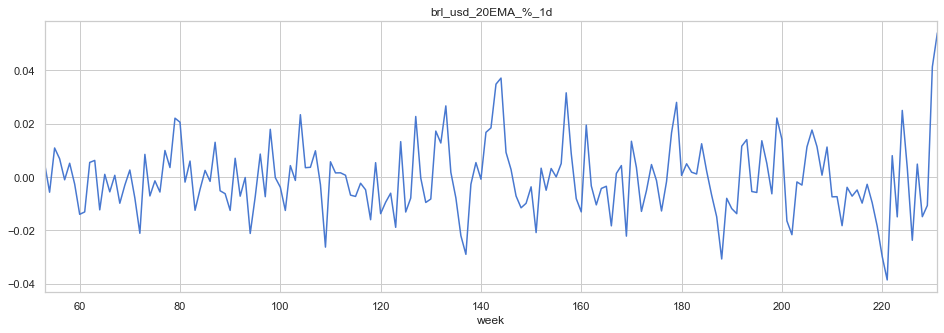

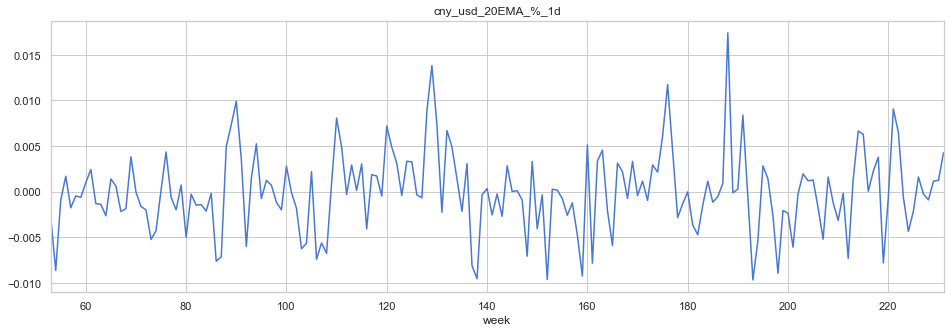

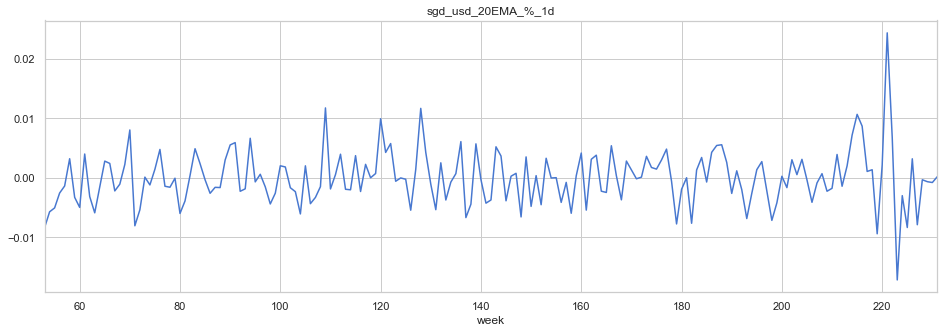

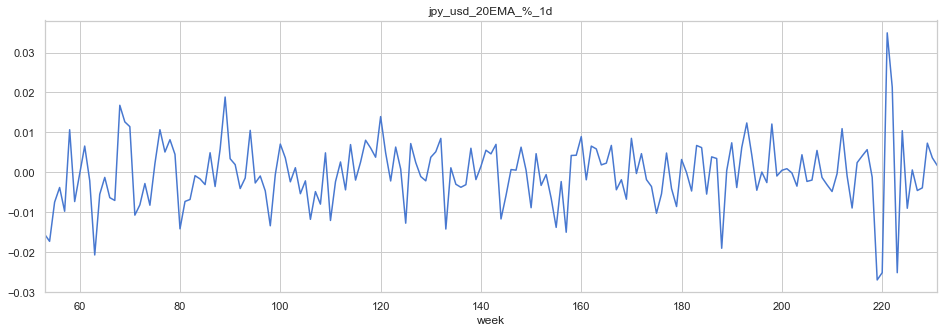

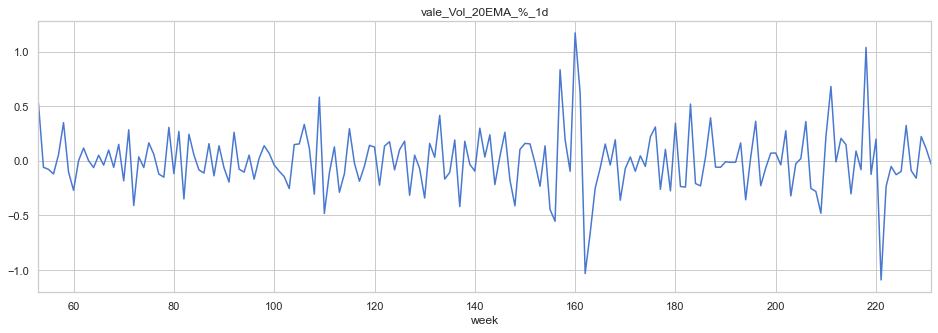

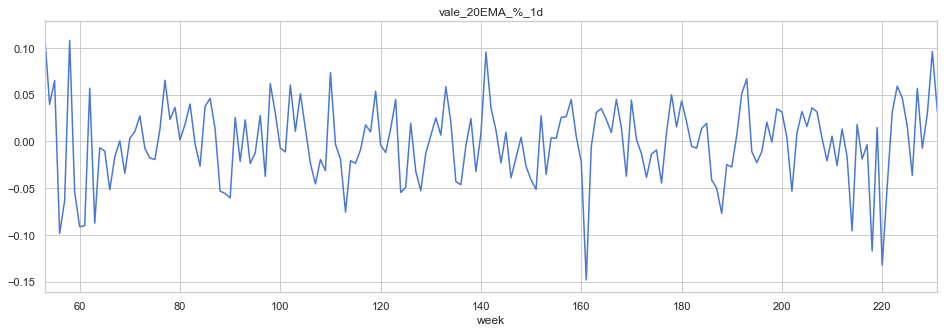

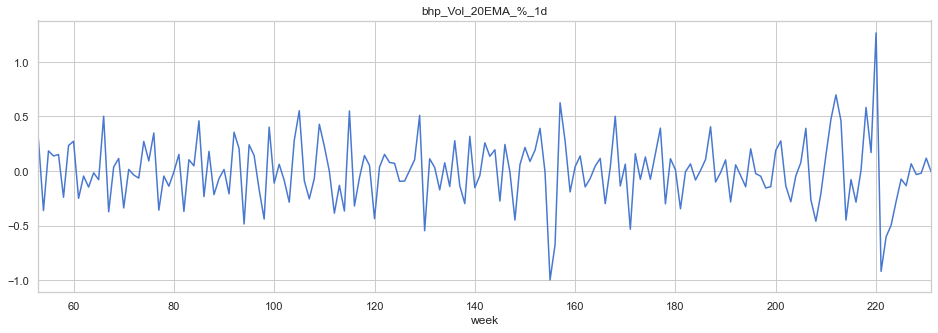

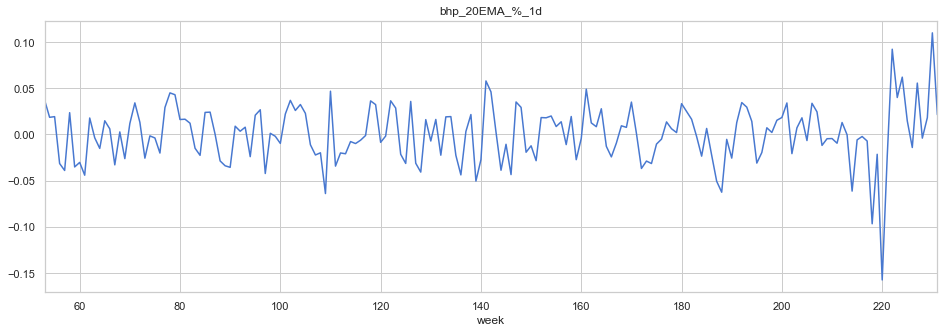

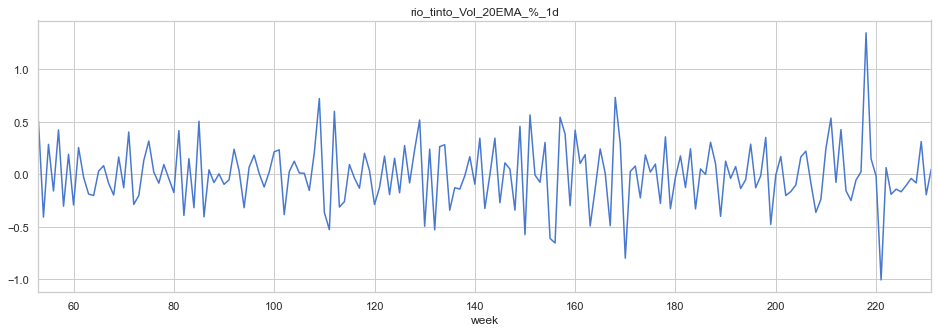

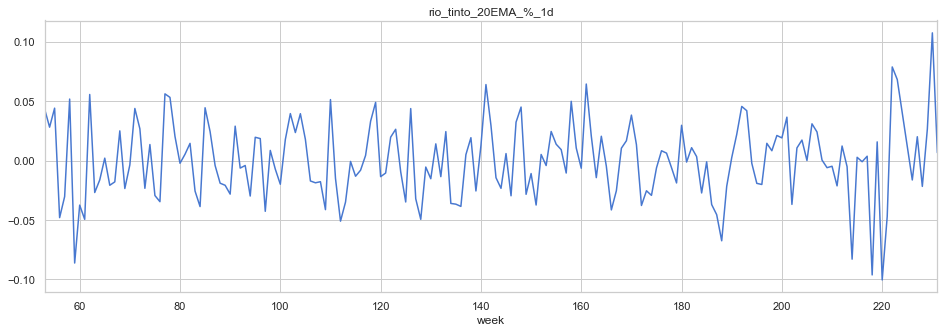

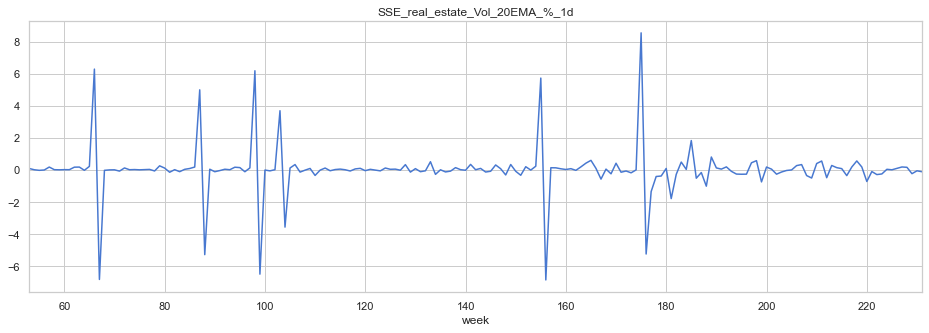

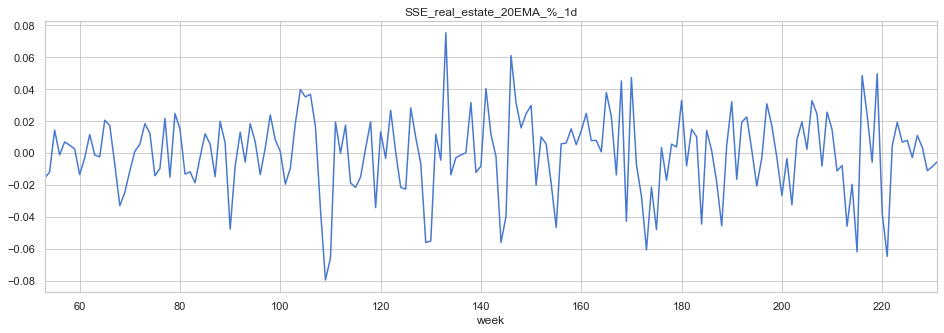

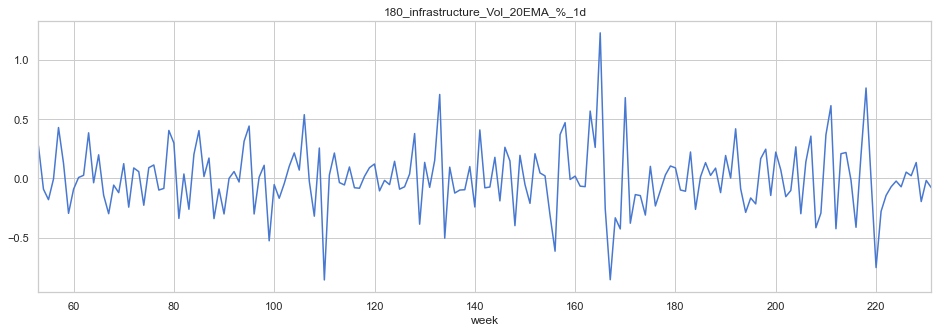

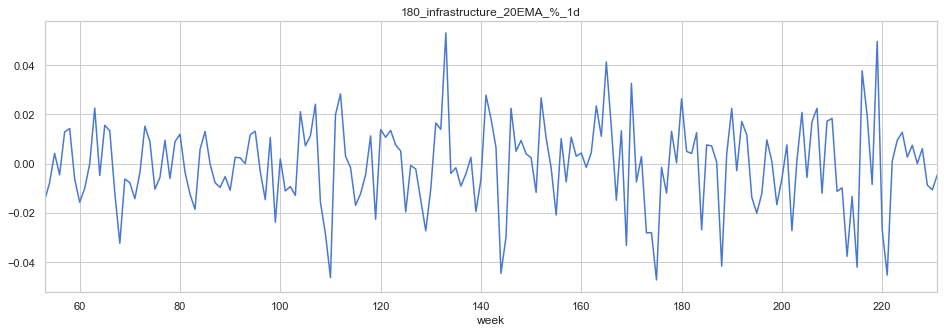

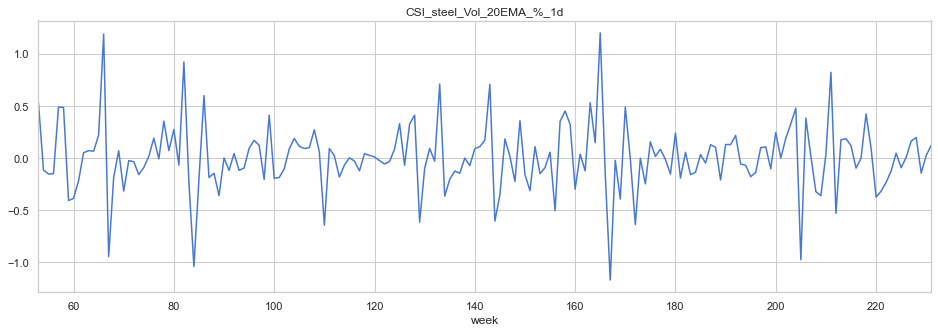

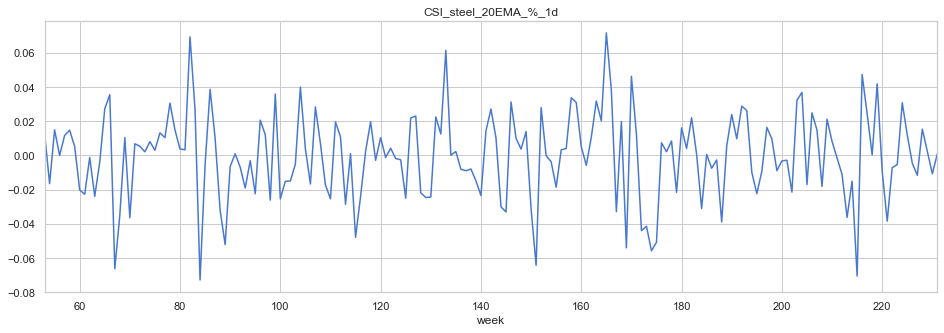

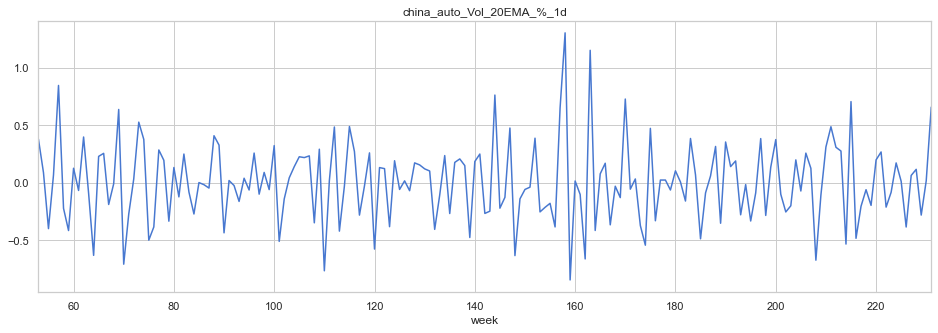

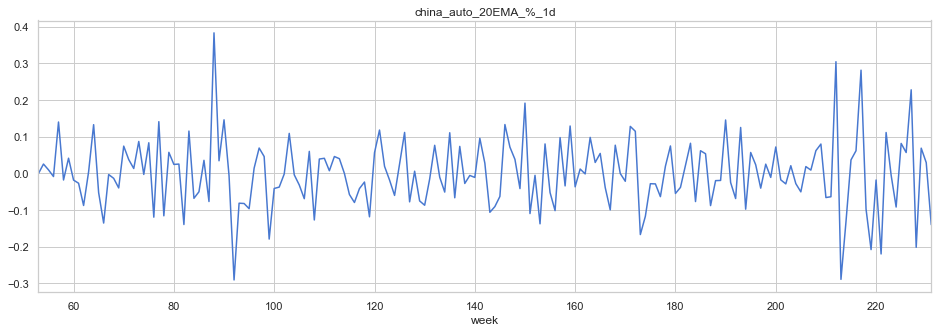

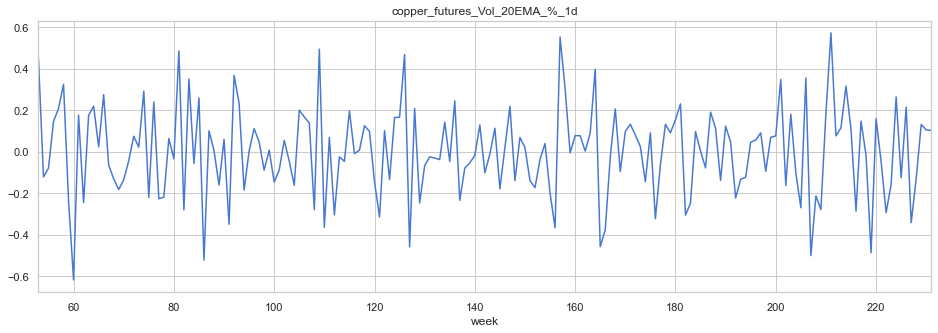

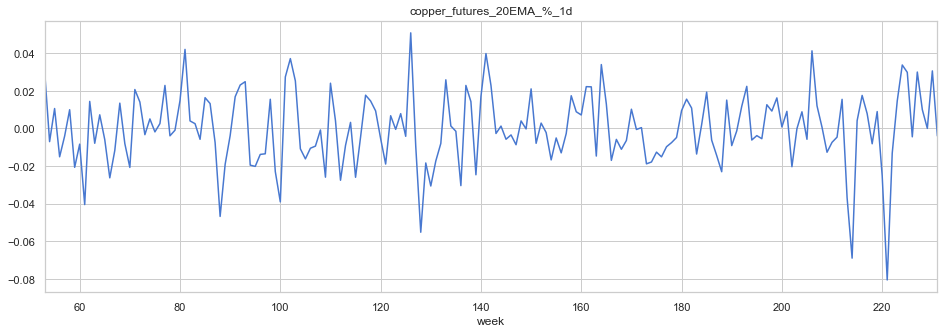

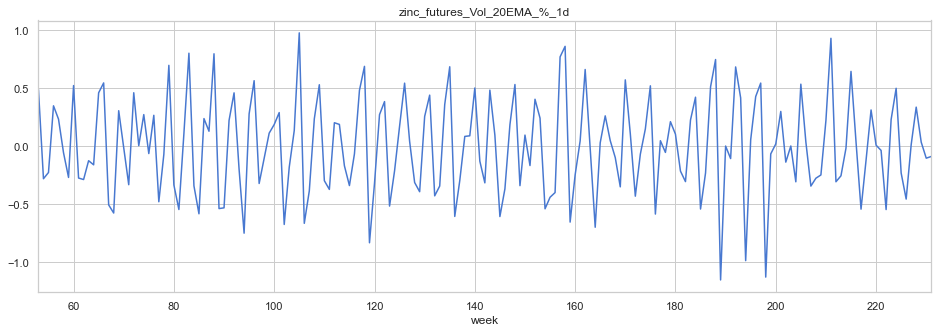

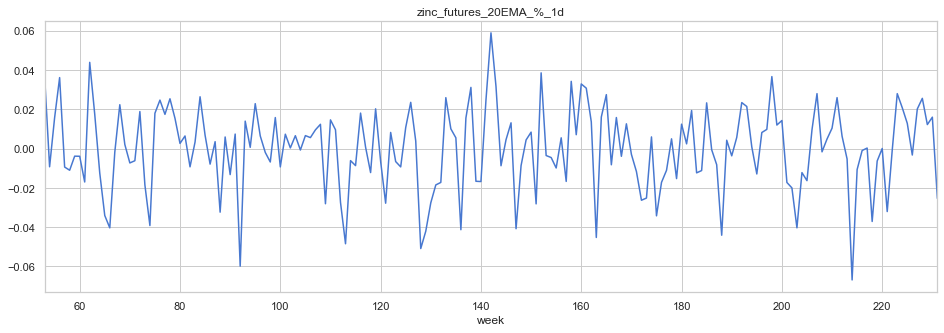

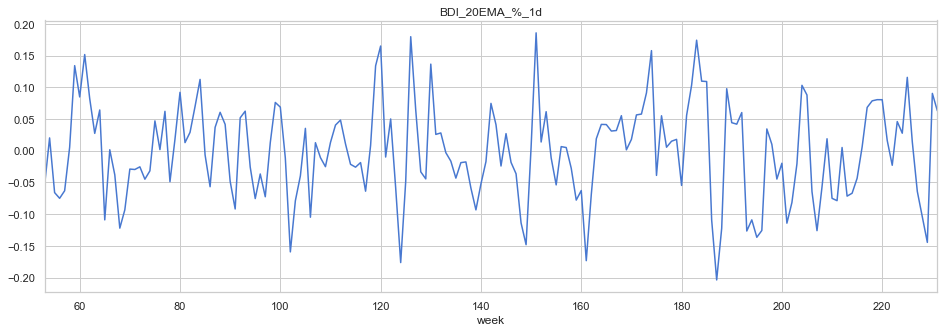

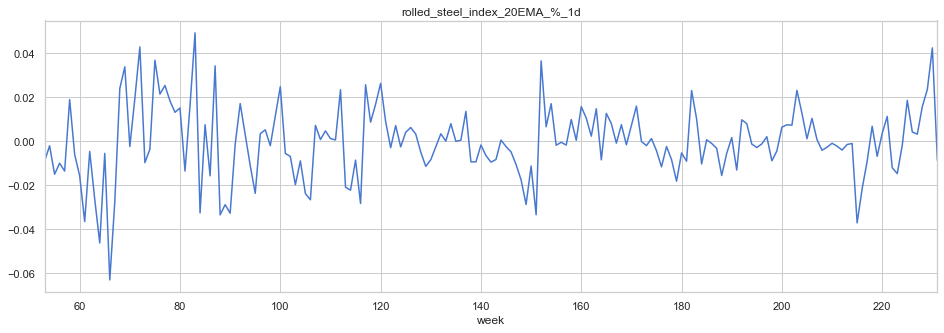

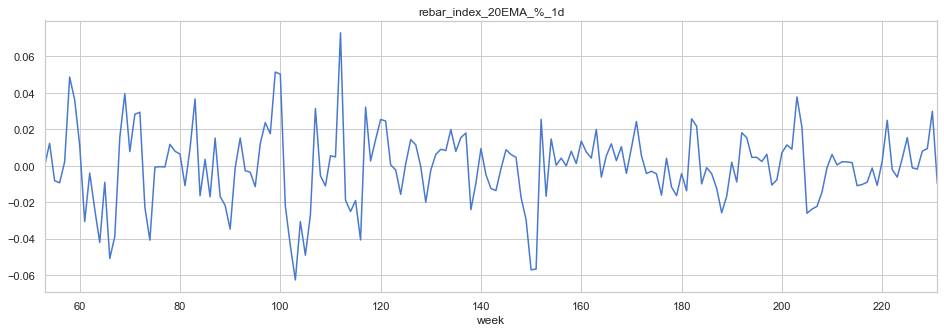

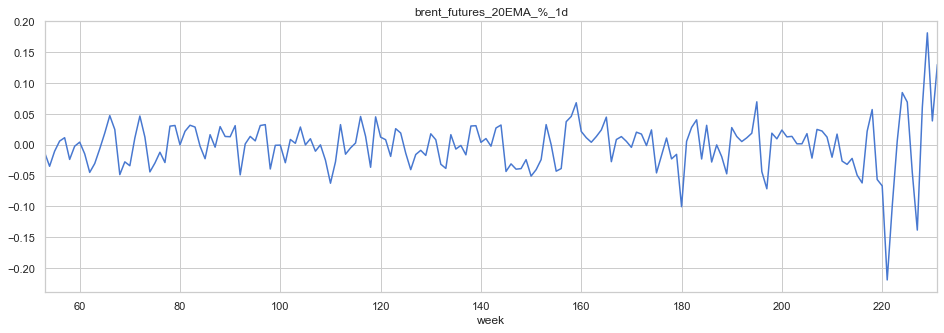

In [24]:
# plot out the features to see if any seasonal pattern

for each in df_EMA_trans.columns[3:]:
    fig, ax = plt.subplots()
    title = each
    xlabel = "week"
    ax = df_EMA_trans[each].plot(figsize=(16,5),title=title)
    ax.autoscale(axis='x', tight=True)
    ax.set(xlabel=xlabel);

# Create lagged versions of Time Series

In [25]:
# a function for creating lag features, create 4 lags, for incorporating the lag effect of 4 weeks

def create_lag(df, each):
    df[each+"_1lag"] = df[each].shift(1)
    df[each+"_2lag"] = df[each].shift(2)
    df[each+"_3lag"] = df[each].shift(3)
    df[each+"_4lag"] = df[each].shift(4)

In [26]:
# take out year, month, week and target

selected = ['DCE_Vol_20EMA_%_1d',  
       'VIX_20EMA_%_1d', 'DJI_Vol_20EMA_%_1d', 'DJI_20EMA_%_1d',
       'FTSE_Vol_20EMA_%_1d', 'FTSE_20EMA_%_1d', 'N225_Vol_20EMA_%_1d',
       'N225_20EMA_%_1d', 'SSE_Composite_Index_Vol_20EMA_%_1d',
       'SSE_Composite_Index_20EMA_%_1d', 'aud_usd_20EMA_%_1d',
       'brl_usd_20EMA_%_1d', 'cny_usd_20EMA_%_1d', 'sgd_usd_20EMA_%_1d',
       'jpy_usd_20EMA_%_1d', 'vale_Vol_20EMA_%_1d', 'vale_20EMA_%_1d',
       'bhp_Vol_20EMA_%_1d', 'bhp_20EMA_%_1d', 'rio_tinto_Vol_20EMA_%_1d',
       'rio_tinto_20EMA_%_1d', 'SSE_real_estate_Vol_20EMA_%_1d',
       'SSE_real_estate_20EMA_%_1d', '180_infrastructure_Vol_20EMA_%_1d',
       '180_infrastructure_20EMA_%_1d', 'CSI_steel_Vol_20EMA_%_1d',
       'CSI_steel_20EMA_%_1d', 'china_auto_Vol_20EMA_%_1d',
       'china_auto_20EMA_%_1d', 'copper_futures_Vol_20EMA_%_1d',
       'copper_futures_20EMA_%_1d', 'zinc_futures_Vol_20EMA_%_1d',
       'zinc_futures_20EMA_%_1d', 'BDI_20EMA_%_1d',
       'rolled_steel_index_20EMA_%_1d', 'rebar_index_20EMA_%_1d',
       'brent_futures_20EMA_%_1d']


In [27]:
for each in selected: 
    create_lag(df_EMA_trans, each)

In [28]:
print(df_EMA_trans.shape)
print()
df_EMA_trans.head(2)

(179, 189)



year month  week  DCE_Vol_20EMA_%_1d  DCE(TARGET)_20EMA_%_1d  \
53  2017   Jan     2            0.129155                0.078364   
54  2017   Jan     3            0.198312                0.081749   

    VIX_20EMA_%_1d  DJI_Vol_20EMA_%_1d  DJI_20EMA_%_1d  FTSE_Vol_20EMA_%_1d  \
53       -0.024170            0.265422       -0.006114             0.287141   
54        0.051218            0.012745       -0.008207            -0.068628   

    FTSE_20EMA_%_1d  N225_Vol_20EMA_%_1d  N225_20EMA_%_1d  \
53         0.007912             0.099779        -0.014853   
54        -0.011921             0.089136        -0.021548   

    SSE_Composite_Index_Vol_20EMA_%_1d  SSE_Composite_Index_20EMA_%_1d  \
53                            0.192452                       -0.004914   
54                           -0.059241                       -0.010228   

    aud_usd_20EMA_%_1d  brl_usd_20EMA_%_1d  cny_usd_20EMA_%_1d  \
53            0.018318            0.005162           -0.002753   
54            0.015958           -0.005684           -0.008650   

    sgd_usd_20EMA_%_1d  jpy_usd_20EMA_%_1d  vale_Vol_20EMA_%_1d  \
53           -0.008446           -0.015453             0.526200   
54           -0.005772           -0.017261            -0.059563   

    vale_20EMA_%_1d  bhp_Vol_20EMA_%_1d  bhp_20EMA_%_1d  \
53         0.116071            0.287325        0.037198   
54         0.039565           -0.361560        0.018415   

    rio_tinto_Vol_20EMA_%_1d  rio_tinto_20EMA_%_1d  \
53                  0.509537              0.043484   
54                 -0.406849              0.028051   

    SSE_real_estate_Vol_20EMA_%_1d  SSE_real_estate_20EMA_%_1d  \
53                        0.081723                   -0.015930   
54                        0.003118                   -0.012111   

    180_infrastructure_Vol_20EMA_%_1d  180_infrastructure_20EMA_%_1d  \
53                           0.273051                      -0.015167   
54                          -0.092027                      -0.007781   

    CSI_steel_Vol_20EMA_%_1d  CSI_steel_20EMA_%_1d  china_auto_Vol_20EMA_%_1d  \
53                  0.529283              0.013234                   0.377116   
54                 -0.115089             -0.016542                   0.086724   

    china_auto_20EMA_%_1d  copper_futures_Vol_20EMA_%_1d  \
53              -0.000737                       0.451260   
54               0.025258                      -0.121461   

    copper_futures_20EMA_%_1d  zinc_futures_Vol_20EMA_%_1d  \
53                   0.030907                     0.489281   
54                  -0.007022                    -0.281004   

    zinc_futures_20EMA_%_1d  BDI_20EMA_%_1d  rolled_steel_index_20EMA_%_1d  \
53                 0.037235       -0.054582                      -0.009144   
54                -0.009294        0.020253                      -0.002131   

    rebar_index_20EMA_%_1d  brent_futures_20EMA_%_1d  DCE_Vol_20EMA_%_1d_1lag  \
53               -0.000254                 -0.012307                      NaN   
54                0.012354                 -0.034898                 0.129155   

    DCE_Vol_20EMA_%_1d_2lag  DCE_Vol_20EMA_%_1d_3lag  DCE_Vol_20EMA_%_1d_4lag  \
53                      NaN                      NaN                      NaN   
54                      NaN                      NaN                      NaN   

    VIX_20EMA_%_1d_1lag  VIX_20EMA_%_1d_2lag  VIX_20EMA_%_1d_3lag  \
53                  NaN                  NaN                  NaN   
54             -0.02417                  NaN                  NaN   

    VIX_20EMA_%_1d_4lag  DJI_Vol_20EMA_%_1d_1lag  DJI_Vol_20EMA_%_1d_2lag  \
53                  NaN                      NaN                      NaN   
54                  NaN                 0.265422                      NaN   

    DJI_Vol_20EMA_%_1d_3lag  DJI_Vol_20EMA_%_1d_4lag  DJI_20EMA_%_1d_1lag  \
53                      NaN                      NaN                  NaN   
54                      NaN                      NaN            -0.

In [29]:
# fill the NaN with zero, after creating lag features

df_EMA_trans = df_EMA_trans.fillna(0)
df_EMA_trans.head()

year month  week  DCE_Vol_20EMA_%_1d  DCE(TARGET)_20EMA_%_1d  \
53  2017   Jan     2            0.129155                0.078364   
54  2017   Jan     3            0.198312                0.081749   
55  2017   Jan     4           -0.094301               -0.018685   
56  2017   Feb     5           -0.685557                0.004866   
57  2017   Feb     6            0.516139               -0.020163   

    VIX_20EMA_%_1d  DJI_Vol_20EMA_%_1d  DJI_20EMA_%_1d  FTSE_Vol_20EMA_%_1d  \
53       -0.024170            0.265422       -0.006114             0.287141   
54        0.051218            0.012745       -0.008207            -0.068628   
55       -0.062208            0.019102        0.005023             0.155480   
56        0.065853           -0.080616       -0.007077            -0.070007   
57       -0.031159           -0.336998        0.005965            -0.077499   

    FTSE_20EMA_%_1d  N225_Vol_20EMA_%_1d  N225_20EMA_%_1d  \
53         0.007912             0.099779        -0.014853   
54        -0.011921             0.089136        -0.021548   
55        -0.013620             0.012515         0.001510   
56        -0.006885            -0.027730        -0.008216   
57         0.008280            -0.039675        -0.004053   

    SSE_Composite_Index_Vol_20EMA_%_1d  SSE_Composite_Index_20EMA_%_1d  \
53                            0.192452                       -0.004914   
54                           -0.059241                       -0.010228   
55                           -0.175668                        0.011897   
56                           -0.036759                        0.001167   
57                            0.343071                        0.004678   

    aud_usd_20EMA_%_1d  brl_usd_20EMA_%_1d  cny_usd_20EMA_%_1d  \
53            0.018318            0.005162           -0.002753   
54            0.015958           -0.005684           -0.008650   
55            0.005426            0.010900           -0.000940   
56            0.000617            0.006857            0.001692   
57            0.004951           -0.001023           -0.001770   

    sgd_usd_20EMA_%_1d  jpy_usd_20EMA_%_1d  vale_Vol_20EMA_%_1d  \
53           -0.008446           -0.015453             0.526200   
54           -0.005772           -0.017261            -0.059563   
55           -0.005114           -0.007461            -0.078841   
56           -0.002610           -0.003785            -0.121139   
57           -0.001422           -0.009733             0.055959   

    vale_20EMA_%_1d  bhp_Vol_20EMA_%_1d  bhp_20EMA_%_1d  \
53         0.116071            0.287325        0.037198   
54         0.039565           -0.361560        0.018415   
55         0.065019            0.184322        0.019128   
56        -0.098380            0.138409       -0.031624   
57        -0.063503            0.151214       -0.039120   

    rio_tinto_Vol_20EMA_%_1d  rio_tinto_20EMA_%_1d  \
53                  0.509537              0.043484   
54                 -0.406849              0.028051   
55                  0.286057              0.044041   
56                 -0.158493             -0.048023   
57                  0.423928             -0.030337   

    SSE_real_estate_Vol_20EMA_%_1d  SSE_real_estate_20EMA_%_1d  \
53                        0.081723                   -0.015930   
54                        0.003118                   -0.012111   
55                       -0.033588                    0.014211   
56                       -0.013387                   -0.001366   
57                        0.171769                    0.006780   

    180_infrastructure_Vol_20EMA_%_1d  180_infrastructure_20EMA_%_1d  \
53                           0.273051                      -0.015167   
54                          -0.092027                      -0.007781   
55                          -0.180152                       0.004129   
56                          -0.005998                      -0.004595   
57                           0.427441                       0.012823   

In [30]:
# create a series of past 4 weeks' mean of the target as a naive prediction for comparsion

past_4_weeks_mean = df_EMA_trans["DCE(TARGET)_20EMA_%_1d"].shift(1).rolling(window=4).mean()

print(past_4_weeks_mean.shape)
past_4_weeks_mean = past_4_weeks_mean.fillna(0).rename("past_4_weeks_mean", axis='columns')
past_4_weeks_mean.head(6)

(179,)


53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.036574
58    0.011942
Name: past_4_weeks_mean, dtype: float64

# Hierarchical Clustering for Time Series Similarity

Feature selection with hierarchical clustering to group time series by their similarities for later handling of multicollinearity.

In [31]:
######## re-do train/ test split after checking stationarity and transformation ######## 

nobs = 30     # using 30 weeks for test set
train, test = df_EMA_trans[0:-nobs], df_EMA_trans[-nobs:]

train_X = train.drop(columns=['year', 'month', 'week', 'DCE(TARGET)_20EMA_%_1d'])
train_y = train['DCE(TARGET)_20EMA_%_1d']

test_X = test.drop(columns=['year', 'month', 'week', 'DCE(TARGET)_20EMA_%_1d'])
test_y = test['DCE(TARGET)_20EMA_%_1d']

In [32]:
print('Shape of train: ', train.shape)
print('Shape of test: ', test.shape)

Shape of train:  (149, 189)
Shape of test:  (30, 189)


In [33]:
# tranpose the dataframe for hierarchical clustering

transposed = train_X.transpose()

print(transposed.shape)
transposed.head(2)

(185, 149)


53        54        55        56        57   \
DCE_Vol_20EMA_%_1d  0.129155  0.198312 -0.094301 -0.685557  0.516139   
VIX_20EMA_%_1d     -0.024170  0.051218 -0.062208  0.065853 -0.031159   

                         58        59        60        61        62   \
DCE_Vol_20EMA_%_1d  0.464167  0.065807  0.150260 -0.047310 -0.016627   
VIX_20EMA_%_1d      0.027735  0.022206  0.040733 -0.023442 -0.005825   

                         63        64        65        66        67   \
DCE_Vol_20EMA_%_1d -0.203012  0.083615 -0.471708  0.508788  0.070749   
VIX_20EMA_%_1d      0.078301 -0.050629  0.046828  0.206585 -0.080629   

                         68        69       70        71        72        73   \
DCE_Vol_20EMA_%_1d  0.248758 -0.237432  0.32101 -0.226737  0.000643 -0.640231   
VIX_20EMA_%_1d     -0.286521 -0.005861 -0.00955  0.199939 -0.181583 -0.007039   

                         74        75        76        77        78   \
DCE_Vol_20EMA_%_1d  0.531841 -0.025576 -0.227917  0.153983  0.044049   
VIX_20EMA_%_1d      0.036474  0.041832 -0.014315  0.025767  0.063388   

                         79        80        81        82        83   \
DCE_Vol_20EMA_%_1d -0.081936  0.055714 -0.022617  0.093294  0.165533   
VIX_20EMA_%_1d     -0.088355 -0.045708  0.018114  0.047188  0.209776   

                         84        85        86        87        88   \
DCE_Vol_20EMA_%_1d -0.242166  0.172141 -0.151109  0.051519 -0.092284   
VIX_20EMA_%_1d      0.022136 -0.105758 -0.090439  0.046065 -0.085208   

                         89        90        91        92        93   \
DCE_Vol_20EMA_%_1d -0.121975 -0.029982  0.002676 -0.054606  0.334373   
VIX_20EMA_%_1d     -0.043458  0.008794 -0.022452  0.050674  0.015894   

                         94        95        96        97        98   \
DCE_Vol_20EMA_%_1d -0.092476 -0.222675  0.211857 -0.102319 -0.022272   
VIX_20EMA_%_1d      0.077570 -0.079560  0.021327  0.148482 -0.172226   

                         99        100       101       102       103  \
DCE_Vol_20EMA_%_1d -0.105022  0.129122  0.073053  0.010607 -0.125500   
VIX_20EMA_%_1d      0.065675  0.007859 -0.076091 -0.003373  0.059153   

                         104       105       106       107       108  \
DCE_Vol_20EMA_%_1d -0.304733  0.175591 -0.073008  0.025052 -0.125819   
VIX_20EMA_%_1d     -0.088356  0.057507  0.138939 -0.026170  0.267944   

                         109       110       111       112       113  \
DCE_Vol_20EMA_%_1d  0.089474 -0.467357 -0.082737  0.488367  0.271235   
VIX_20EMA_%_1d      1.110435 -0.866009 -0.241326 -0.029968 -0.158360   

                         114       115       116       117       118  \
DCE_Vol_20EMA_%_1d  0.042889  0.378412 -0.208783 -0.278950  0.400846   
VIX_20EMA_%_1d     -0.067023  0.239079 -0.006412 -0.050569 -0.102664   

                         119       120       121       122       123  \
DCE_Vol_20EMA_%_1d  0.242712 -0.394215 -0.563488  0.536195 -0.098726   
VIX_20EMA_%_1d     -0.209904  0.043099 -0.062470 -0.097264  0.002588   

                         124       125       126       127       128  \
DCE_Vol_20EMA_%_1d -0.181287  0.034988 -0.038904 -0.155809 -0.119521   
VIX_20EMA_%_1d     -0.024116  0.124989 -0.147960  0.023768  0.077703   

                         129       130       131       132       133  \
DCE_Vol_20EMA_%_1d  0.183214 -0.051534 -0.058972 -0.188990  0.130931   
VIX_20EMA_%_1d      0.217382 -0.104897 -0.152242 -0.000495  0.009118   

                         134       135       136       137       138  \
DCE_Vol_20EMA_%_1d  0.128095  0.163211 -0.055310 -0.107573 -0.169979   
VIX_20EMA_%_1d      0.031621 -0.076677  0.163323 -0.087409  0.026388   

                         139       140       141       142       143  \
DCE_Vol_20EMA_%_1d  0.174836  0.030155 -0.189537 -0.125656  0.024957   
VIX_20EMA_%_1d      0.088609 -0.060289 -0.039054  0.012500  0.043055   

                         144       145       146       147       148  \
DCE_Vol_20EMA_%_1d  

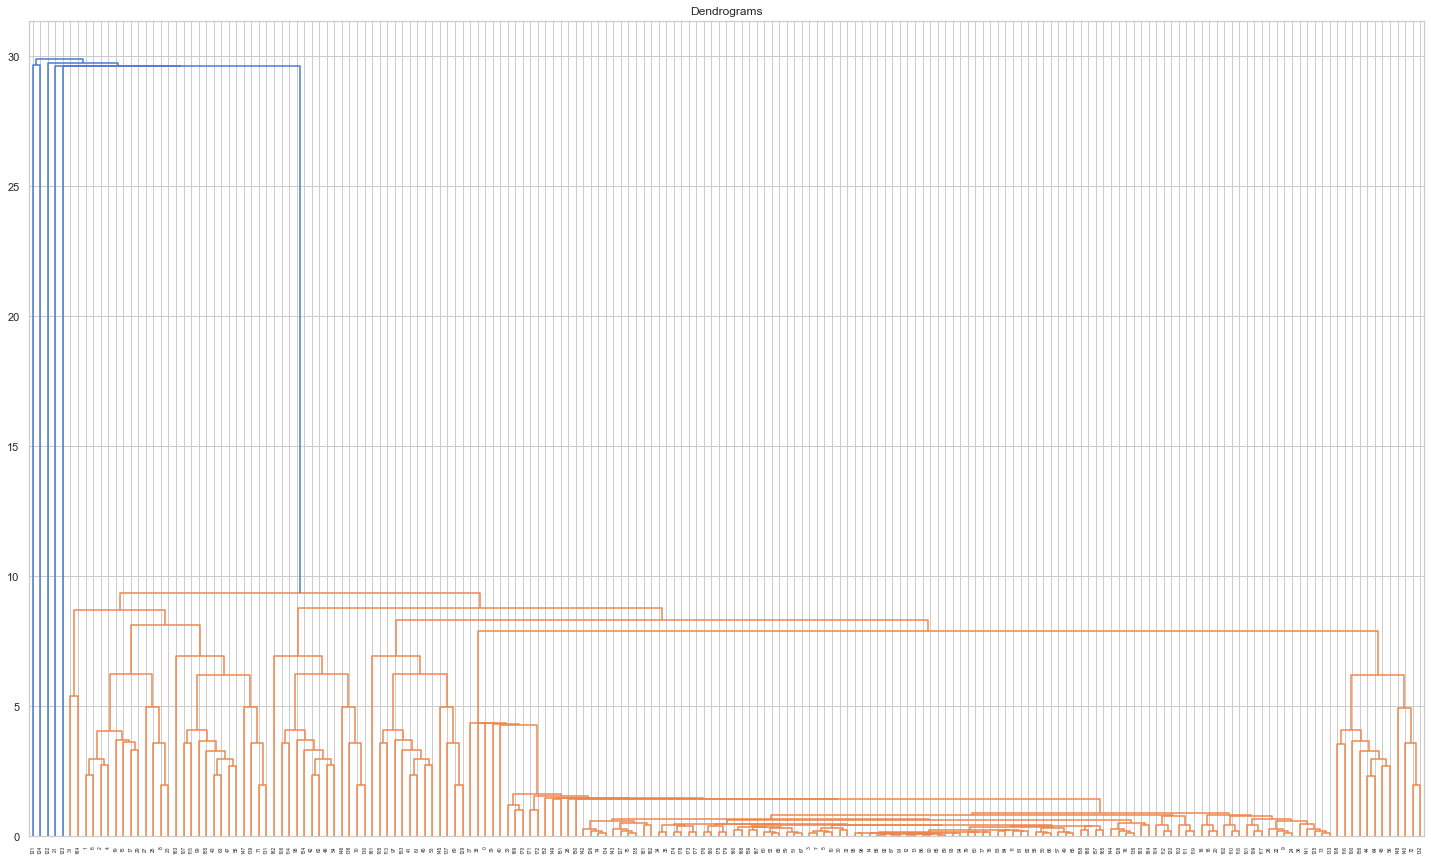

In [34]:
# produce dendrogram for 1st run

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(25, 15))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(transposed, method='ward'))
#plt.axhline(y=7 , color="r", linestyle="--");

In [35]:
# apply hierarchical clustering for 2 clusters 

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage='ward')
cluster.fit_predict(transposed)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
transposed['cluster'] = cluster.fit_predict(transposed)
transposed['cluster'].value_counts()

0    180
5      1
4      1
3      1
2      1
1      1
Name: cluster, dtype: int64

In [37]:
for i in range(transposed['cluster'].nunique()):
    print(transposed[transposed['cluster']==i]['cluster'])
    print("===============================")
    print()

DCE_Vol_20EMA_%_1d                         0
VIX_20EMA_%_1d                             0
DJI_Vol_20EMA_%_1d                         0
DJI_20EMA_%_1d                             0
FTSE_Vol_20EMA_%_1d                        0
FTSE_20EMA_%_1d                            0
N225_Vol_20EMA_%_1d                        0
N225_20EMA_%_1d                            0
SSE_Composite_Index_Vol_20EMA_%_1d         0
SSE_Composite_Index_20EMA_%_1d             0
aud_usd_20EMA_%_1d                         0
brl_usd_20EMA_%_1d                         0
cny_usd_20EMA_%_1d                         0
sgd_usd_20EMA_%_1d                         0
jpy_usd_20EMA_%_1d                         0
vale_Vol_20EMA_%_1d                        0
vale_20EMA_%_1d                            0
bhp_Vol_20EMA_%_1d                         0
bhp_20EMA_%_1d                             0
rio_tinto_Vol_20EMA_%_1d                   0
rio_tinto_20EMA_%_1d                       0
SSE_real_estate_20EMA_%_1d                 0
180_infras

In [38]:
# from the result of 1st run, there are a few individual clusters, so they are taken out and re-run thr algorithm again

transposed = transposed.drop(["SSE_real_estate_Vol_20EMA_%_1d_4lag",
                              "SSE_real_estate_Vol_20EMA_%_1d_3lag",
                              "SSE_real_estate_Vol_20EMA_%_1d_2lag",
                              "SSE_real_estate_Vol_20EMA_%_1d_1lag",
                              "SSE_real_estate_Vol_20EMA_%_1d",
                                  ], axis=0)
transposed.shape

(180, 150)

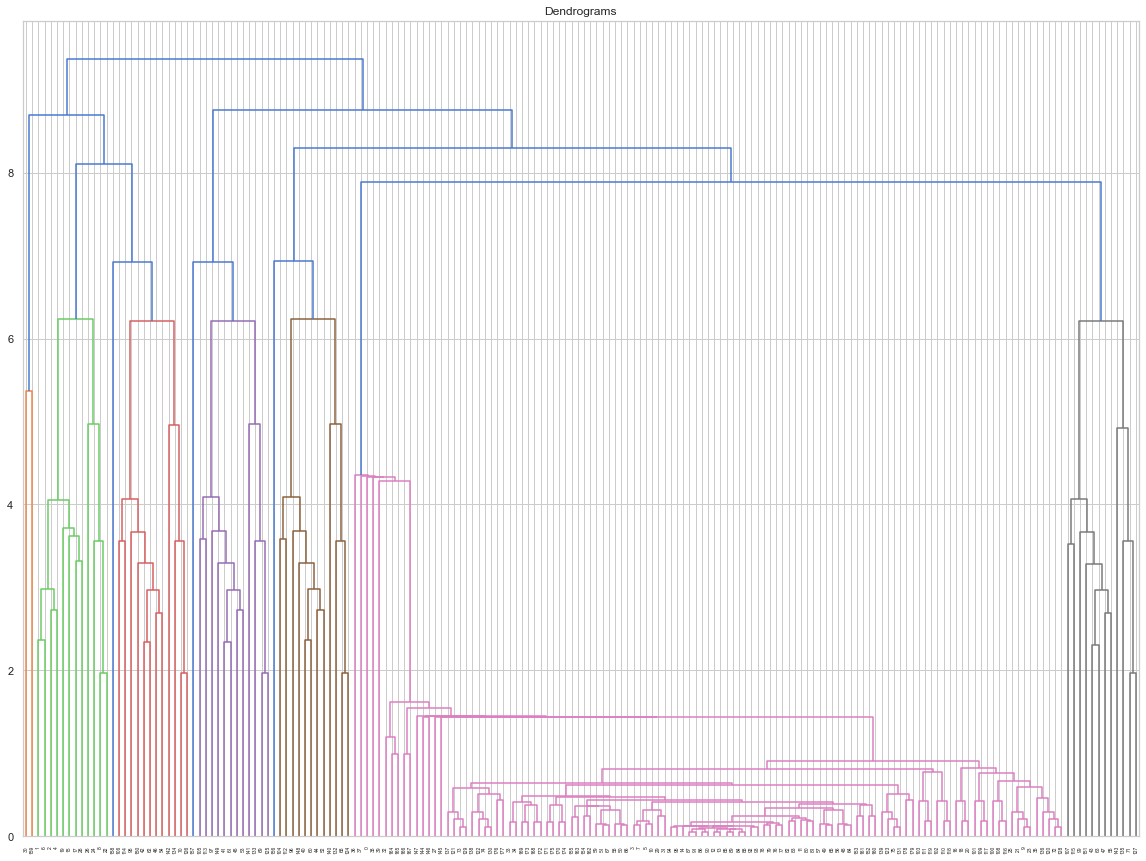

In [39]:
# produce dendrogram for 2nd run for transposed

plt.figure(figsize=(20, 15))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(transposed, method='ward'))
#plt.axhline(y=7 , color="r", linestyle="--");

In [40]:
# apply hierarchical clustering for 15 clusters 

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=15, affinity="euclidean", linkage='ward')
cluster.fit_predict(transposed)

array([ 6, 10, 10,  6, 10,  6, 10,  6,  2,  6,  6,  6,  6,  6,  6, 10,  6,
       10,  6, 10,  6,  6,  2,  6,  2,  6,  2,  6, 10,  6,  0,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 11, 12, 13, 14, 11, 12, 13, 14,  6,  6,  6,
        6, 11, 12, 13, 14,  6,  6,  6,  6, 11, 12, 13, 14,  6,  6,  6,  6,
        1,  5,  3,  4,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 11, 12, 13, 14,  6,  6,
        6,  6, 11, 12, 13, 14,  6,  6,  6,  6, 11, 12, 13, 14,  6,  6,  6,
        6,  6,  6,  6,  6,  1,  5,  3,  4,  6,  6,  6,  6,  1,  5,  3,  4,
        6,  6,  6,  6,  1,  5,  3,  4,  6,  6,  6,  6, 11, 12, 13, 14,  6,
        6,  6,  6,  7,  8,  9,  0,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [41]:
transposed['cluster'] = cluster.fit_predict(transposed)
transposed['cluster'].value_counts()

6     115
14      8
13      8
12      8
11      8
10      8
5       4
4       4
3       4
2       4
1       4
0       2
9       1
8       1
7       1
Name: cluster, dtype: int64

In [42]:
for i in range(transposed['cluster'].nunique()):
    print(transposed[transposed['cluster']==i]['cluster'])
    print("===============================")
    print()

zinc_futures_Vol_20EMA_%_1d         0
zinc_futures_Vol_20EMA_%_1d_4lag    0
Name: cluster, dtype: int64

SSE_Composite_Index_Vol_20EMA_%_1d_1lag    1
180_infrastructure_Vol_20EMA_%_1d_1lag     1
CSI_steel_Vol_20EMA_%_1d_1lag              1
china_auto_Vol_20EMA_%_1d_1lag             1
Name: cluster, dtype: int64

SSE_Composite_Index_Vol_20EMA_%_1d    2
180_infrastructure_Vol_20EMA_%_1d     2
CSI_steel_Vol_20EMA_%_1d              2
china_auto_Vol_20EMA_%_1d             2
Name: cluster, dtype: int64

SSE_Composite_Index_Vol_20EMA_%_1d_3lag    3
180_infrastructure_Vol_20EMA_%_1d_3lag     3
CSI_steel_Vol_20EMA_%_1d_3lag              3
china_auto_Vol_20EMA_%_1d_3lag             3
Name: cluster, dtype: int64

SSE_Composite_Index_Vol_20EMA_%_1d_4lag    4
180_infrastructure_Vol_20EMA_%_1d_4lag     4
CSI_steel_Vol_20EMA_%_1d_4lag              4
china_auto_Vol_20EMA_%_1d_4lag             4
Name: cluster, dtype: int64

SSE_Composite_Index_Vol_20EMA_%_1d_2lag    5
180_infrastructure_Vol_20EMA_%_1d_

In [43]:
# again take ou the individual clusters

transposed = transposed.drop(["zinc_futures_Vol_20EMA_%_1d_1lag",
                              "zinc_futures_Vol_20EMA_%_1d_2lag",
                              "zinc_futures_Vol_20EMA_%_1d_3lag",
                             ], axis=0)
transposed.shape

(177, 150)

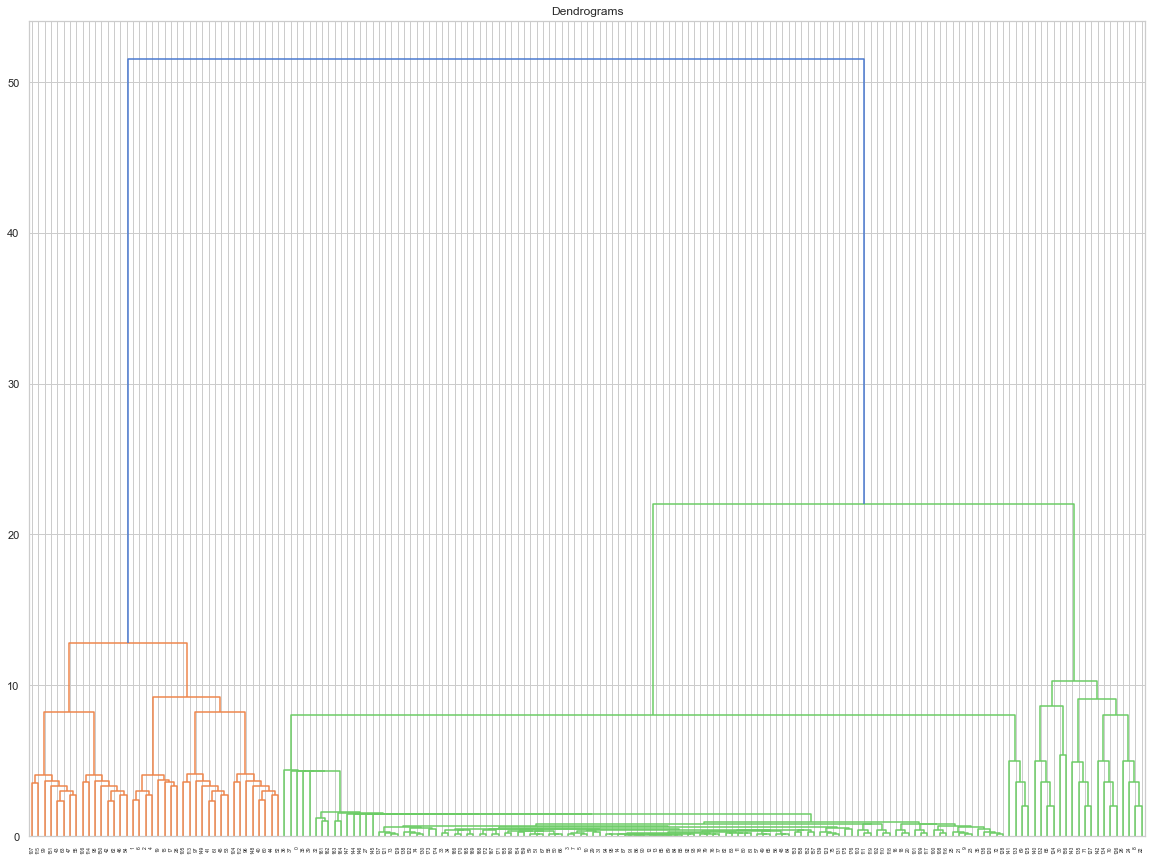

In [44]:
# produce dendrogram for 3rd run for transposed

plt.figure(figsize=(20, 15))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(transposed, method='ward'))
#plt.axhline(y=7 , color="r", linestyle="--");

Only two major cluster left, let us stop here.

# Find out the most representative candidate from each cluster

Running Mutual Information Regression with each cluster, except the individual clusters, to find out the feature with the highest Mutal Information with the target.

In [45]:
from sklearn.feature_selection import f_regression, mutual_info_regression

cluster_list_transposed = [0,1,2,3,4,5,6,10,11,12,13,14]  # do not consider the clusters with only 1 candidate

In [46]:
selected_features_transposed = []

for each in cluster_list_transposed:
    temp = mutual_info_regression(train_X[transposed[transposed['cluster']==each]['cluster'].index], 
                                  train_y)
    
    print('Cluster', each, ": " )
    print()
    print(temp)
    print()
    print('Feature with highest MI in the cluster: ', 
          transposed[transposed['cluster']==each]['cluster'].index[np.argmax(temp)])
    
    selected_features_transposed.append(transposed[transposed['cluster']==each]['cluster'].index[np.argmax(temp)])
    print()
    print("================================================================")
    print()

Cluster 0 : 

[0.         0.09127088]

Feature with highest MI in the cluster:  zinc_futures_Vol_20EMA_%_1d_4lag


Cluster 1 : 

[0.05744872 0.         0.10681578 0.11243283]

Feature with highest MI in the cluster:  china_auto_Vol_20EMA_%_1d_1lag


Cluster 2 : 

[0.08285101 0.         0.13007951 0.072119  ]

Feature with highest MI in the cluster:  CSI_steel_Vol_20EMA_%_1d


Cluster 3 : 

[0.01168449 0.         0.07976724 0.12953476]

Feature with highest MI in the cluster:  china_auto_Vol_20EMA_%_1d_3lag


Cluster 4 : 

[0.        0.0463919 0.        0.0487453]

Feature with highest MI in the cluster:  china_auto_Vol_20EMA_%_1d_4lag


Cluster 5 : 

[0.0634885  0.00239249 0.07501451 0.        ]

Feature with highest MI in the cluster:  CSI_steel_Vol_20EMA_%_1d_2lag


Cluster 6 : 

[6.91321110e-02 5.02559467e-02 0.00000000e+00 7.38029649e-02
 2.45949917e-02 0.00000000e+00 6.69526025e-02 1.30488516e-01
 0.00000000e+00 0.00000000e+00 1.58028192e-01 4.94318441e-02
 1.33072715e-01 1.795659

In [47]:
# combine the list of features resulted from the Mutual Information Regression with the features that form individual cluster

selected_features = selected_features_transposed  + ["SSE_real_estate_Vol_20EMA_%_1d_4lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_3lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_2lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_1lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d",
                                                      "zinc_futures_Vol_20EMA_%_1d_1lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_2lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_3lag",
                                                     ]


print("No. of selected features: ", len(selected_features))

No. of selected features:  20


In [48]:
selected_features

['zinc_futures_Vol_20EMA_%_1d_4lag',
 'china_auto_Vol_20EMA_%_1d_1lag',
 'CSI_steel_Vol_20EMA_%_1d',
 'china_auto_Vol_20EMA_%_1d_3lag',
 'china_auto_Vol_20EMA_%_1d_4lag',
 'CSI_steel_Vol_20EMA_%_1d_2lag',
 'rolled_steel_index_20EMA_%_1d',
 'N225_Vol_20EMA_%_1d',
 'vale_Vol_20EMA_%_1d_1lag',
 'rio_tinto_Vol_20EMA_%_1d_2lag',
 'VIX_20EMA_%_1d_3lag',
 'N225_Vol_20EMA_%_1d_4lag',
 'SSE_real_estate_Vol_20EMA_%_1d_4lag',
 'SSE_real_estate_Vol_20EMA_%_1d_3lag',
 'SSE_real_estate_Vol_20EMA_%_1d_2lag',
 'SSE_real_estate_Vol_20EMA_%_1d_1lag',
 'SSE_real_estate_Vol_20EMA_%_1d',
 'zinc_futures_Vol_20EMA_%_1d_1lag',
 'zinc_futures_Vol_20EMA_%_1d_2lag',
 'zinc_futures_Vol_20EMA_%_1d_3lag']

# Multicollinearity Handling with Variance Inflation Factor (VIF)

No or little multicollinearity between the independent variables is a key assumption of OLS regression, so VIF is adapted to find out features with high VIF score.


In [49]:
# a function for calculating VIF

def cal_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [50]:
cal_vif(train[selected_features])

variables       VIF
0      zinc_futures_Vol_20EMA_%_1d_4lag  2.629589
1        china_auto_Vol_20EMA_%_1d_1lag  1.351044
2              CSI_steel_Vol_20EMA_%_1d  1.244539
3        china_auto_Vol_20EMA_%_1d_3lag  1.455575
4        china_auto_Vol_20EMA_%_1d_4lag  1.377999
5         CSI_steel_Vol_20EMA_%_1d_2lag  1.289814
6         rolled_steel_index_20EMA_%_1d  1.112868
7                   N225_Vol_20EMA_%_1d  1.380384
8              vale_Vol_20EMA_%_1d_1lag  1.198039
9         rio_tinto_Vol_20EMA_%_1d_2lag  1.322119
10                  VIX_20EMA_%_1d_3lag  1.216185
11             N225_Vol_20EMA_%_1d_4lag  1.339508
12  SSE_real_estate_Vol_20EMA_%_1d_4lag  1.731524
13  SSE_real_estate_Vol_20EMA_%_1d_3lag  2.441767
14  SSE_real_estate_Vol_20EMA_%_1d_2lag  2.638291
15  SSE_real_estate_Vol_20EMA_%_1d_1lag  2.316164
16       SSE_real_estate_Vol_20EMA_%_1d  1.673937
17     zinc_futures_Vol_20EMA_%_1d_1lag  2.613805
18     zinc_futures_Vol_20EMA_%_1d_2lag  2.476376
19     zinc_futures_Vol_20EMA_%_1d_3lag  2.355071

In [51]:
# drop features with VIF value over 2.5 and test it again

cal_vif(df_EMA_trans[selected_features].drop(columns=["SSE_real_estate_Vol_20EMA_%_1d_3lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_2lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_1lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_4lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_2lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_1lag"
                                                     ]))

variables       VIF
0        china_auto_Vol_20EMA_%_1d_1lag  1.160621
1              CSI_steel_Vol_20EMA_%_1d  1.218636
2        china_auto_Vol_20EMA_%_1d_3lag  1.315003
3        china_auto_Vol_20EMA_%_1d_4lag  1.254274
4         CSI_steel_Vol_20EMA_%_1d_2lag  1.142272
5         rolled_steel_index_20EMA_%_1d  1.061476
6                   N225_Vol_20EMA_%_1d  1.133142
7              vale_Vol_20EMA_%_1d_1lag  1.117315
8         rio_tinto_Vol_20EMA_%_1d_2lag  1.077410
9                   VIX_20EMA_%_1d_3lag  1.077485
10             N225_Vol_20EMA_%_1d_4lag  1.158926
11  SSE_real_estate_Vol_20EMA_%_1d_4lag  1.083161
12       SSE_real_estate_Vol_20EMA_%_1d  1.091848
13     zinc_futures_Vol_20EMA_%_1d_3lag  1.176990

In [52]:
# drop out the features with VIF score from the set

selected_features = [x for x in selected_features if x not in ["SSE_real_estate_Vol_20EMA_%_1d_3lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_2lag",
                                                      "SSE_real_estate_Vol_20EMA_%_1d_1lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_4lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_2lag",
                                                      "zinc_futures_Vol_20EMA_%_1d_1lag"
                                                               ]]

print(len(selected_features))
selected_features

14


['china_auto_Vol_20EMA_%_1d_1lag',
 'CSI_steel_Vol_20EMA_%_1d',
 'china_auto_Vol_20EMA_%_1d_3lag',
 'china_auto_Vol_20EMA_%_1d_4lag',
 'CSI_steel_Vol_20EMA_%_1d_2lag',
 'rolled_steel_index_20EMA_%_1d',
 'N225_Vol_20EMA_%_1d',
 'vale_Vol_20EMA_%_1d_1lag',
 'rio_tinto_Vol_20EMA_%_1d_2lag',
 'VIX_20EMA_%_1d_3lag',
 'N225_Vol_20EMA_%_1d_4lag',
 'SSE_real_estate_Vol_20EMA_%_1d_4lag',
 'SSE_real_estate_Vol_20EMA_%_1d',
 'zinc_futures_Vol_20EMA_%_1d_3lag']

# Recursive Feature Elimination (RFE)

Final step of feature selection, apply RFE to find out final set of selected features

In [53]:
len(selected_features)

14

In [54]:
# choose a model

estimator = LinearRegression()
#estimator = Ridge(alpha=0.05, normalize=False)
#estimator = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False, random_state=0)

# set up the KFold
#folds = tscv

# set up the RFECV
selector = RFECV(estimator=estimator, step=1, scoring='neg_mean_squared_error') #, cv=folds)
selector = selector.fit(train_X[selected_features], train_y)  

print("Features to be retained: ", selector.support_)
print("Ranking: ", selector.ranking_)

Features to be retained:  [False  True False False False  True False False False False False False
 False False]
Ranking:  [ 7  1 11  3 13  1  6  5  4 12  2 10  8  9]


Optimal number of features : 2



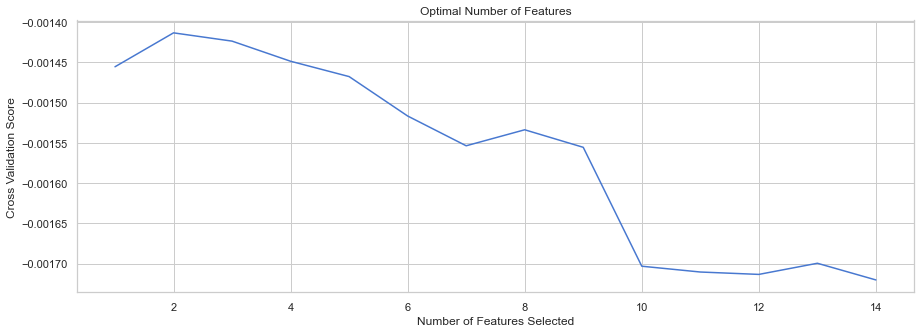

In [55]:
print("Optimal number of features : %d" % selector.n_features_)
print()

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Optimal Number of Features')
plt.show()

In [56]:
final_selected = list(compress(selected_features, selector.support_))

print("No. of final features: ", len(final_selected))

No. of final features:  2


In [57]:
final_selected

['CSI_steel_Vol_20EMA_%_1d', 'rolled_steel_index_20EMA_%_1d']

In [58]:
# update the train and test sets with the final selected list of features

train_X = train_X[final_selected]
test_X = test_X[final_selected]

print('Shape of Train: ', train_X.shape)
print('Shape of Test: ', test_X.shape)

Shape of Train:  (149, 2)
Shape of Test:  (30, 2)


In [59]:
train_X.head()

CSI_steel_Vol_20EMA_%_1d  rolled_steel_index_20EMA_%_1d
53                  0.529283                      -0.009144
54                 -0.115089                      -0.002131
55                 -0.154494                      -0.015019
56                 -0.150059                      -0.010025
57                  0.487817                      -0.013578

# Model Building

As there are only 2 features being retained in the feature selection operation, a simple linear regression is trained, instead of a regularized Ridge regression

In [60]:
model = sm.OLS(train_y, train_X)
reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     DCE(TARGET)_20EMA_%_1d   R-squared (uncentered):                   0.317
Model:                                OLS   Adj. R-squared (uncentered):              0.308
Method:                     Least Squares   F-statistic:                              34.18
Date:                    Fri, 02 Apr 2021   Prob (F-statistic):                    6.47e-13
Time:                            22:28:05   Log-Likelihood:                          280.95
No. Observations:                     149   AIC:                                     -557.9
Df Residuals:                         147   BIC:                                     -551.9
Df Model:                               2                                                  
Covariance Type:                nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CSI_steel_Vol_20EMA_%_1d          0.0257      0.009      2.761      0.006       0.007       0.044
rolled_steel_index_20EMA_%_1d     1.3743      0.180      7.634      0.000       1.019       1.730
==============================================================================
Omnibus:                       24.056   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.959
Skew:                          -0.628   Prob(JB):                     9.55e-14
Kurtosis:                       5.843   Cond. No.                         19.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
print("=======================================================================")
print("Train's RMSE: ", np.sqrt(mean_squared_error(train_y, reg.predict(train_X[final_selected]))))
print("Test's RMSE: ", np.sqrt(mean_squared_error(test_y, reg.predict(test_X[final_selected]))))
print("RMSE of past 4 weeks' mean: ", np.sqrt(mean_squared_error(test_y, past_4_weeks_mean[-nobs:])))

Train's RMSE:  0.03671789333446986
Test's RMSE:  0.033479696369578316
RMSE of past 4 weeks' mean:  0.043620898388852934


In [62]:
reg.params

CSI_steel_Vol_20EMA_%_1d         0.025728
rolled_steel_index_20EMA_%_1d    1.374253
dtype: float64

In [63]:
df_EMA_trans['Forecast_ridge'] = np.concatenate((reg.predict(train_X), reg.predict(test_X)))
df_EMA_trans['Forecast_ridge'].shape

(179,)

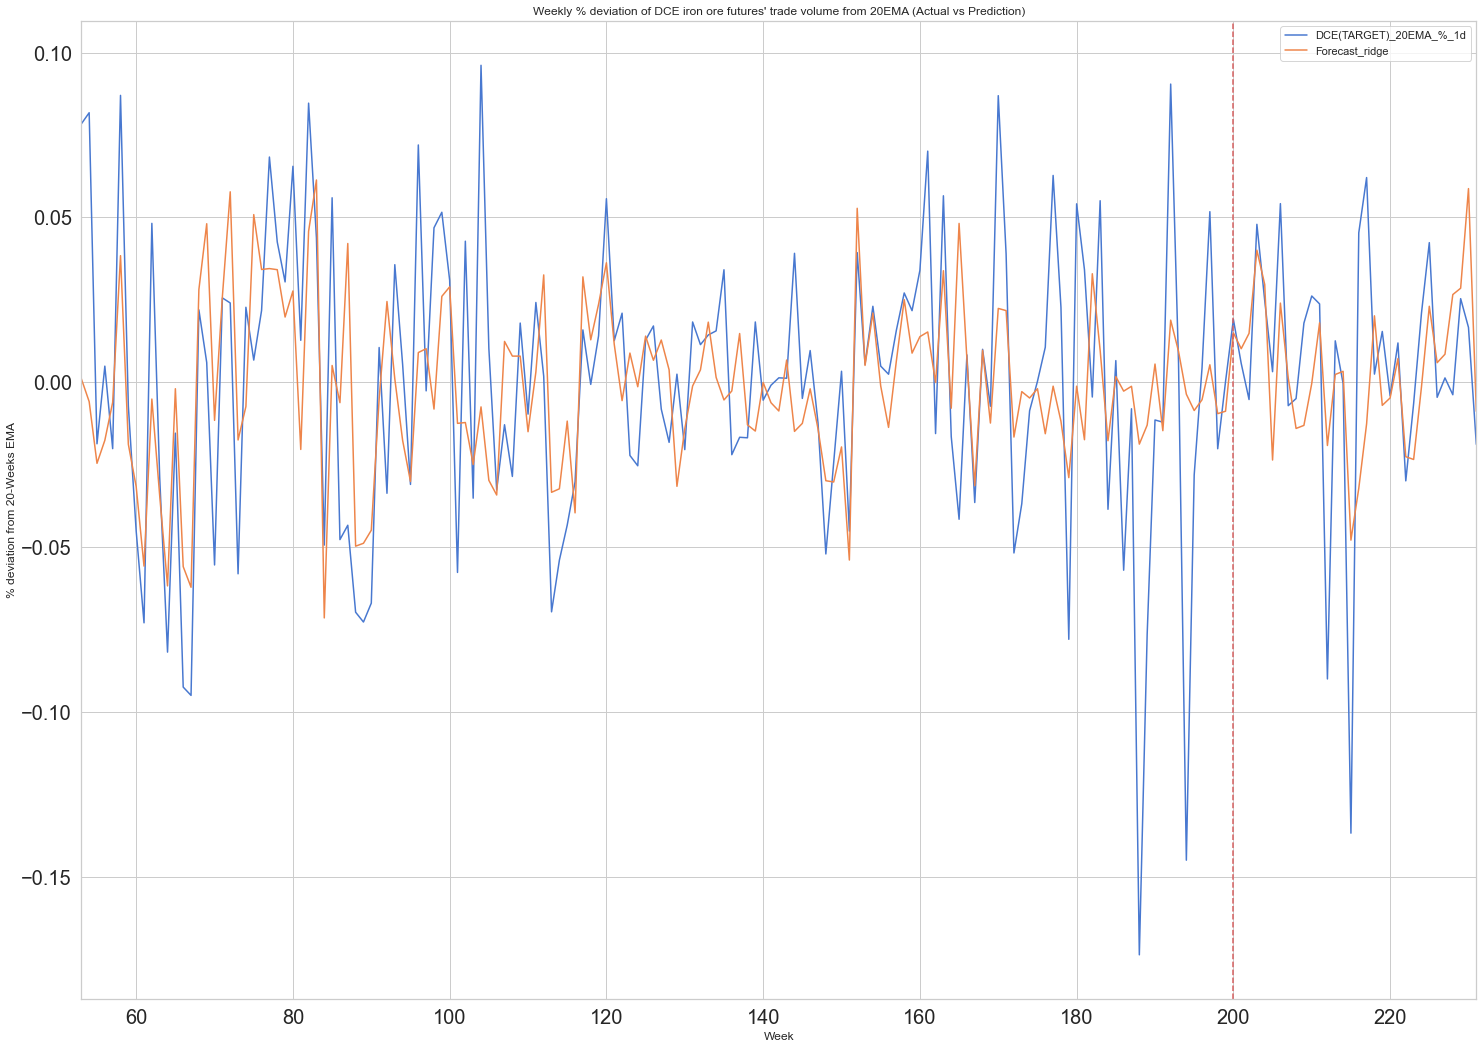

In [64]:
# plot the actual and the prediction (whole period)

title = 'Weekly % deviation of DCE iron ore futures\' trade volume from 20EMA (Actual vs Prediction)'
ylabel = '% deviation from 20-Weeks EMA'
xlabel = 'Week'

ax = df_EMA_trans['DCE(TARGET)_20EMA_%_1d'].plot(figsize=(25,18), title=title,legend=True, fontsize=20)
df_EMA_trans['Forecast_ridge'].plot(legend=True);

plt.axvline(x=200, color="r", linestyle="--") 

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

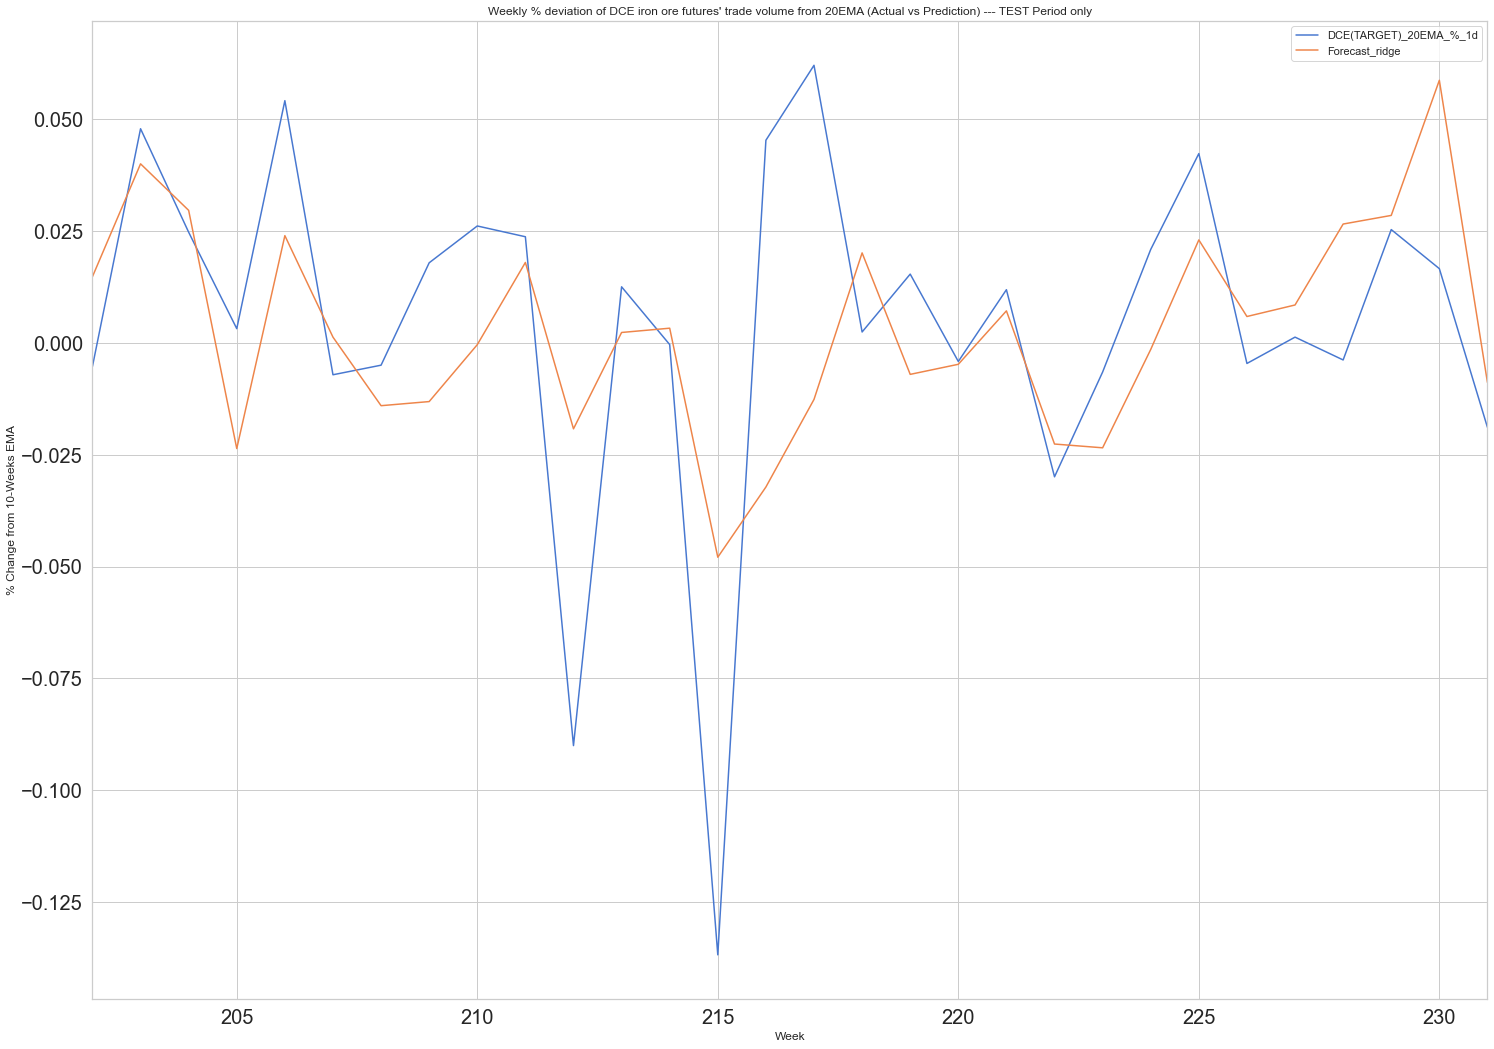

In [65]:
# plot the actual and the prediction (test period only)

title = 'Weekly % deviation of DCE iron ore futures\' trade volume from 20EMA (Actual vs Prediction) --- TEST Period only'
ylabel = '% Change from 10-Weeks EMA'
xlabel = 'Week'
                                                                 
ax = df_EMA_trans['DCE(TARGET)_20EMA_%_1d'][-nobs:].plot(figsize=(25,18), title=title,legend=True, fontsize=20)
df_EMA_trans['Forecast_ridge'][-nobs:].plot(legend=True);
    
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

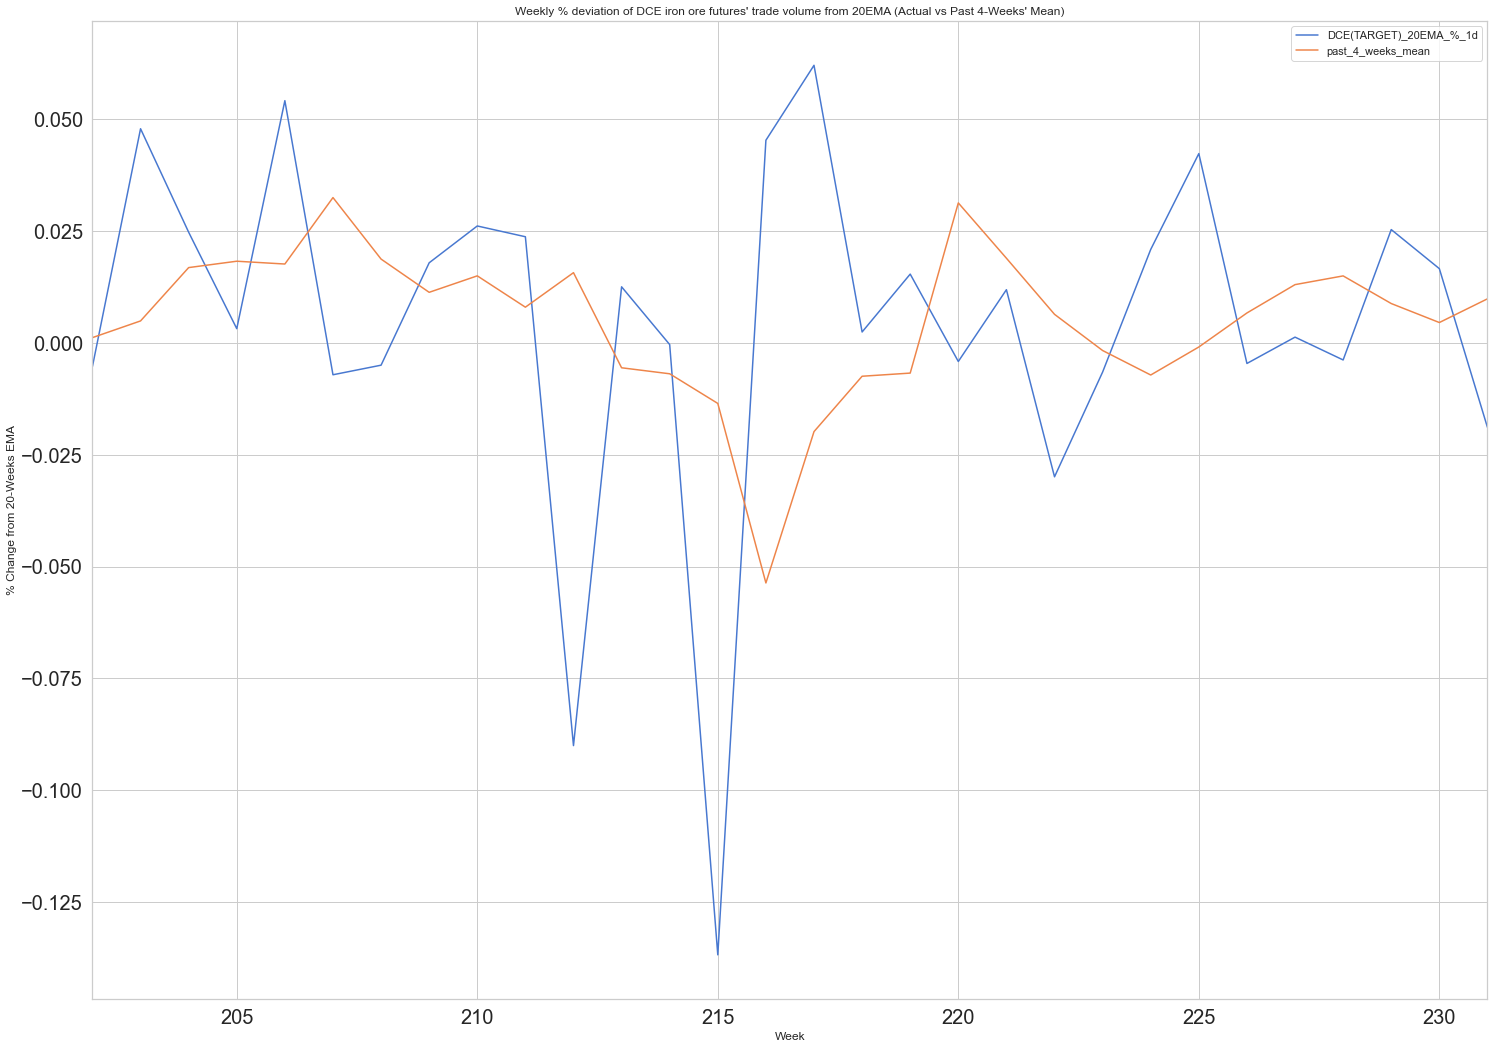

In [66]:
# plot the actual and the Past 4-Weeks' Mean

title = 'Weekly % deviation of DCE iron ore futures\' trade volume from 20EMA (Actual vs Past 4-Weeks\' Mean)'
ylabel = '% Change from 20-Weeks EMA'
xlabel = 'Week'

ax = df_EMA_trans['DCE(TARGET)_20EMA_%_1d'][-nobs:].plot(figsize=(25,18), title=title,legend=True, fontsize=20)
past_4_weeks_mean[-nobs:].plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Residual Inspection

Check for the residuals of the regression model to make sure homoscedasticity assumption is not violated.

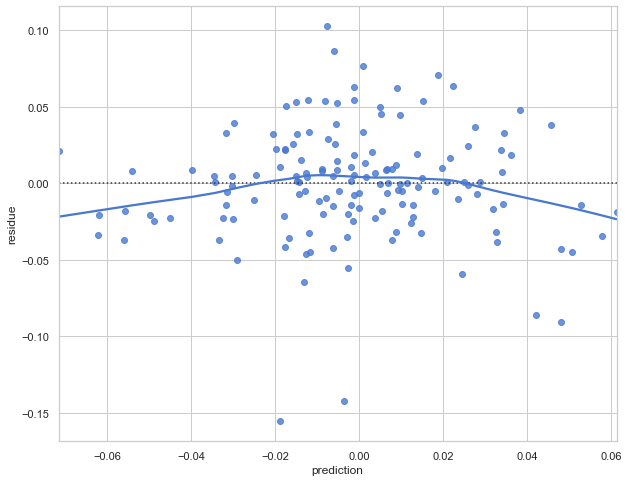

In [67]:
plt.rcParams["figure.figsize"] = (10,8)
ax = sns.residplot(reg.predict(train_X), reg.resid, lowess=True)
ax.set(xlabel="prediction", ylabel="residue");

From the residual plot, no obvious cluster or trend is be found.

# Conclusion

From the summary of the OLS regression, both the coefficients of the independent variables are positive, so the two independent variables correlate positively with the dependent variable. Moreover, the value of the coefficient of Rolled Steel Index: 1.3743 is larger than the one of CSI Steel Index's trade volume: 0.0257, thus Rolled Steel Index correlate stronger with the response variable than CSI Steel Index's trade volume does. 

Since correlation does not imply causation, the two final selected features may not drive the trade price of Dalian Commodity Exchange's iron ore futures. However, if there is a surge of those two factors, the trade price of the iron ore futures may likely increase. Also, it does make sense that the trade price of the iron ore futures correlates with the Rolled Steel Index, which is the average spot price of the end product of iron ore.